# Module 1 Project

Please fill out:
* Student name: Jennifer Wadkins
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Jeff Herman
* Blog post URL:



Questions I have:
    * Do I need to justify not using provided data, or can I just go straight for my own?
    * Am I allowed to make some assumptions/framing for the case study, ex. set in a pre-covid world?

## Project Overview

## Importing our modules

We will be using the following libraries in this project:

pandas, numpy, matplotlib, json, re

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import json
import re
%matplotlib inline

## Other preparation work

Recommended to also install the nbextensions "Table of Contents 2" and "Collapsible Headings" for easier navigation through this notebook.

Gitbhub here: https://github.com/ipython-contrib/jupyter_contrib_nbextensions

## Project Steps

    1) Open, explore, and perform necessary cleaning on provided data sets. Determine need for additional data and acquire it via API calls and web scraping. Decide on most robust data to use as the "master" set.
    2) Merge data sets into larger data sets as needed. Clean further until working with robust data.
    3) EDA on data sets including visualizations

## Notebook Functions

In [2]:
def string_cleanup(text):
    '''takes in an object, converts to string, and removes all non-word characters'''
    text = str(text)
    result = re.sub(r"[,@\'?\.$%_:â()-]", "", text, flags=re.I)
    result = re.sub(r"\s+"," ", result, flags = re.I)
    return result

# Project Step 1 - Data Aquisition and Cleaning

Open, explore, and perform necessary cleaning on provided data sets. Determine need for additional data and acquire it via API calls and web scraping. Decide on most robust data to use as the "master" set.

## Source 1 - The Movie Database

First we will look at our provided data set from TMDB and see how they need cleaning. When performing cleaning analysis on ALL datasets in this project, we initially want to know things like:

    * What is the shape of our imported data?
    * How many data entries?
    * What format is the data in?
    * How can we remove the most obvious redundancies (columns we just don't need, etc)
    * Are there missing/null values in the dataset that will need to be removed or imputed?

### Exploring the Data - original TMDB file

In [3]:
# importing the movie database movies data set from file
tmdb = pd.read_csv('zippedData/tmdb.movies.csv')

In [4]:
# taking a look at what we've imported
tmdb.head(10)

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186
5,5,"[12, 14, 10751]",32657,en,Percy Jackson & the Olympians: The Lightning T...,26.691,2010-02-11,Percy Jackson & the Olympians: The Lightning T...,6.1,4229
6,6,"[28, 12, 14, 878]",19995,en,Avatar,26.526,2009-12-18,Avatar,7.4,18676
7,7,"[16, 10751, 35]",10193,en,Toy Story 3,24.445,2010-06-17,Toy Story 3,7.7,8340
8,8,"[16, 10751, 35]",20352,en,Despicable Me,23.673,2010-07-09,Despicable Me,7.2,10057
9,9,"[16, 28, 35, 10751, 878]",38055,en,Megamind,22.855,2010-11-04,Megamind,6.8,3635


In [5]:
# what is the shape of our data?
tmdb.shape
# this dataset has 26,517 movie entries. At first glance we are very excited about all of this data!

(26517, 10)

In [6]:
# what kind of data is stored?
tmdb.dtypes
# Most of the data in this set seems to be stored in the correct format already (numbers as numbers, etc)
# we'll change the date to a proper date/time

Unnamed: 0             int64
genre_ids             object
id                     int64
original_language     object
original_title        object
popularity           float64
release_date          object
title                 object
vote_average         float64
vote_count             int64
dtype: object

In [7]:
# do we have any missing/null values?
tmdb.isnull().sum()
# This dataset has no missing values. That doesn't mean there aren't categorical placeholders, and we will look into that further


Unnamed: 0           0
genre_ids            0
id                   0
original_language    0
original_title       0
popularity           0
release_date         0
title                0
vote_average         0
vote_count           0
dtype: int64

In [8]:
tmdb.describe()
# One thing we can see in this dataset is that there are a LOT of movies with 5 or fewer votes. A full 50% of the dataset
# has 5 or fewer votes. The difference between or 75th percentile and the max goes from 28 to 22,000 votes!!
# We will look more into this and figure out the situation.

,Unnamed: 0,id,popularity,vote_average,vote_count
count,26517.00000,26517.000000,26517.000000,26517.000000,26517.000000
mean,13258.00000,295050.153260,3.130912,5.991281,194.224837
std,7654.94288,153661.615648,4.355229,1.852946,960.961095
min,0.00000,27.000000,0.600000,0.000000,1.000000
25%,6629.00000,157851.000000,0.600000,5.000000,2.000000
50%,13258.00000,309581.000000,1.374000,6.000000,5.000000
75%,19887.00000,419542.000000,3.694000,7.000000,28.000000
max,26516.00000,608444.000000,80.773000,10.000000,22186.000000


In [9]:
tmdb['vote_count'].value_counts()
# There are 6541 entries in this dataset with only 1 votex

1       6541
2       3044
3       1757
4       1347
5        969
        ... 
2328       1
6538       1
489        1
2600       1
2049       1
Name: vote_count, Length: 1693, dtype: int64

In [10]:
tmdb.sort_values('popularity')
# while sorting on popularity, I also notice for the first time that a lot of the genre_ids on this low popularity list are absent


,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
13258,13258,[99],403294,en,9/11: Simulations,0.600,2014-07-04,9/11: Simulations,10.0,1
11010,11010,[],203325,en,Slaves Body,0.600,2013-06-25,Slaves Body,0.5,1
11011,11011,[99],186242,en,Re-Emerging: The Jews of Nigeria,0.600,2013-05-17,Re-Emerging: The Jews of Nigeria,0.5,2
11012,11012,[99],116868,en,Occupation: Fighter,0.600,2013-08-02,Occupation: Fighter,0.5,2
11013,11013,[99],85337,en,Wonders Are Many: The Making of Doctor Atomic,0.600,2013-08-07,Wonders Are Many: The Making of Doctor Atomic,0.5,2
...,...,...,...,...,...,...,...,...,...,...
5179,5179,"[878, 28, 12]",24428,en,The Avengers,50.289,2012-05-04,The Avengers,7.6,19673
11020,11020,"[28, 12, 14]",122917,en,The Hobbit: The Battle of the Five Armies,53.783,2014-12-17,The Hobbit: The Battle of the Five Armies,7.3,8392
23812,23812,"[28, 12, 16, 878, 35]",324857,en,Spider-Man: Into the Spider-Verse,60.534,2018-12-14,Spider-Man: Into the Spider-Verse,8.4,4048
11019,11019,"[28, 53]",245891,en,John Wick,78.123,2014-10-24,John Wick,7.2,10081


In [11]:
tmdb[(tmdb['vote_count'] > 30)].count()
# we only have 6347 entries in this dataset with more than 30 user votes. I question the quality of this dataset.
# Overall, this might just not be great data, and since we have access to a TMDB API, we will pull better data
# ourselves

Unnamed: 0           6347
genre_ids            6347
id                   6347
original_language    6347
original_title       6347
popularity           6347
release_date         6347
title                6347
vote_average         6347
vote_count           6347
dtype: int64

### Pulling Data from TMDB via API

Instead of using the provided data set from TMDB, we're going to pull the specific movie data that we want to use from TMDB using an API key. 

We're accessing the API documentation for TMDB at https://developers.themoviedb.org/3/getting-started/introduction, after registering for an API key.

We can see some interesting options with the TMDB API that want to add to our data including:
    * Movie genre list to match up with the genre-ids (under Genres)
    * More up-to-date dataset in general, retrieved with some predetermined data refinement critera 
    * A list of the IMDB movie ids, which will be incredibly helpful for us to join this TMDB info with our IMDB info later in the notebook (under Movies -> Get External IDs)
    


### Movie Genres Matchup

TMDB also allows for browser-based API calls, which works well for small simple calls. We used their browser system for this simple call, copied the text results into our source code editor, and saved as a JSON

We used https://developers.themoviedb.org/3/genres/get-movie-list to get a JSON dictionary of movie genres.

In [12]:
# We saved the resulting web-based text return as a JSON using our source code editor, and now we load it
f = open('api_data/tmdb_movie_genres.json')
data = json.load(f)
data

{'genres': [{'id': 28, 'name': 'Action'},
  {'id': 12, 'name': 'Adventure'},
  {'id': 16, 'name': 'Animation'},
  {'id': 35, 'name': 'Comedy'},
  {'id': 80, 'name': 'Crime'},
  {'id': 99, 'name': 'Documentary'},
  {'id': 18, 'name': 'Drama'},
  {'id': 10751, 'name': 'Family'},
  {'id': 14, 'name': 'Fantasy'},
  {'id': 36, 'name': 'History'},
  {'id': 27, 'name': 'Horror'},
  {'id': 10402, 'name': 'Music'},
  {'id': 9648, 'name': 'Mystery'},
  {'id': 10749, 'name': 'Romance'},
  {'id': 878, 'name': 'Science Fiction'},
  {'id': 10770, 'name': 'TV Movie'},
  {'id': 53, 'name': 'Thriller'},
  {'id': 10752, 'name': 'War'},
  {'id': 37, 'name': 'Western'}]}

In [13]:
genres = data['genres']

tmdb_genres = {}

for x in range(len(genres)):
    key = genres[x]['id']
    value = genres[x]['name']
    tmdb_genres[key] = value
    
tmdb_genres

# This did what we want, but WE CAN DO BETTER.

{28: 'Action',
 12: 'Adventure',
 16: 'Animation',
 35: 'Comedy',
 80: 'Crime',
 99: 'Documentary',
 18: 'Drama',
 10751: 'Family',
 14: 'Fantasy',
 36: 'History',
 27: 'Horror',
 10402: 'Music',
 9648: 'Mystery',
 10749: 'Romance',
 878: 'Science Fiction',
 10770: 'TV Movie',
 53: 'Thriller',
 10752: 'War',
 37: 'Western'}

### Discover Data Set

The big workhorse API for TMDB is in "Discover" located at https://developers.themoviedb.org/3/discover/movie-discover

In this section we can get back a data set that can, in some ways, be pre-cleaned. So we are going to determine how we plan to refine/clean our data set right now, and then figure out ways that we can pull data from TMDB that already fits the parameters we want.

Here are the data cleanup steps we are planning for our data set, some of which can be achieved while we grab the data:

    * Drop entries with fewer than 30 votes. Our client is looking for a blockbuster, not a bespoke production.
    * Drop entries with no genre specified. We'll want to use the genre to make recommendations.
    * Drop entries with 1.0 or less popularity, for the same reasons as votes
    * Drop movies older than 2000. We want a relatively current dataset in order to make proper recommendations.
    
The Discover API lets us pass the following useful parameters to fulfill some of our data refinement goals:
    * primary_release_date.gte lets us include movies that have a primary release date greater or equal than the specified value
    * primary_release_date.lte lets us pass a primary release date lesser than or equal than the specified value. This will keep our scope in 2019 or older for purposes of our case study. We're looking at movie production in a pre-covid world.
    * vote_count.gte lets us filter for movies with a vote count greater than or equal to the specified value
    * with_original_language lets us pull english language films. Our client will be making films in english

This will take care of a few of the things we wanted to clean up in our dataset.
 
We're getting this and other API data in a separate notebook, because we don't want to make these API calls every time we run this notebook! We've pulled the data via the notebook called "tmdb_api_calls" and saved it as a JSON file, and will now import our JSON file here for further processing.

#### !!!!! STOP !!!!! Go to the notebook at tmdb_api_calls.ipynb and run the first section titled "Discover Data Set" now.

Alternatively, load in the provided csv below where we have already done this task.

In [14]:
# opening up our Discover dataset

f = open('api_data/tmdb_movies.json', encoding='utf-8')
discover = json.load(f)

type(discover) # we've loaded our Discover dataset and it's a dictionary

dict

In [15]:
discover.keys() # checking the keys
# we ran our function to paginate in the API and as a result, our keys are each of the 500 calls we made to the api. We'll
# need to go a level lower to hit our data.

dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157'

In [16]:
# what does the first level of our dictionary look like?
discover['1']
# This is page 1 of the results

discover['1']['results']
# these are the entries on page 1. Our plan now is to write a loop to iterate through the pages, and concatenate the 
# results onto our dataframe tmdb_discover

[{'popularity': 520.621,
  'vote_count': 12639,
  'video': False,
  'poster_path': '/gGEsBPAijhVUFoiNpgZXqRVWJt2.jpg',
  'id': 354912,
  'adult': False,
  'backdrop_path': '/askg3SMvhqEl4OL52YuvdtY40Yb.jpg',
  'original_language': 'en',
  'original_title': 'Coco',
  'genre_ids': [16, 10751, 35, 12, 14, 10402],
  'title': 'Coco',
  'vote_average': 8.2,
  'overview': "Despite his family’s baffling generations-old ban on music, Miguel dreams of becoming an accomplished musician like his idol, Ernesto de la Cruz. Desperate to prove his talent, Miguel finds himself in the stunning and colorful Land of the Dead following a mysterious chain of events. Along the way, he meets charming trickster Hector, and together, they set off on an extraordinary journey to unlock the real story behind Miguel's family history.",
  'release_date': '2017-10-27'},
 {'popularity': 330.357,
  'vote_count': 15378,
  'video': False,
  'poster_path': '/udDclJoHjfjb8Ekgsd4FDteOkCU.jpg',
  'id': 475557,
  'adult': Fal

In [17]:
tmdb_discover = pd.DataFrame() #start by making an empty dataframe to hold our results

# loop through each page of our response JSON, make it into a dataframe, and concatenate onto our big dataframe
for x in discover:
    df = pd.DataFrame.from_dict(discover[x]['results'])
    tmdb_discover = pd.concat([tmdb_discover, df])

tmdb_discover #finished dataframe

,popularity,vote_count,video,poster_path,id,adult,backdrop_path,original_language,original_title,genre_ids,title,vote_average,overview,release_date
0,520.621,12639,False,/gGEsBPAijhVUFoiNpgZXqRVWJt2.jpg,354912,False,/askg3SMvhqEl4OL52YuvdtY40Yb.jpg,en,Coco,"[16, 10751, 35, 12, 14, 10402]",Coco,8.2,Despite his family’s baffling generations-old ...,2017-10-27
1,330.357,15378,False,/udDclJoHjfjb8Ekgsd4FDteOkCU.jpg,475557,False,/n6bUvigpRFqSwmPp1m2YADdbRBc.jpg,en,Joker,"[80, 53, 18]",Joker,8.2,"During the 1980s, a failed stand-up comedian i...",2019-10-02
2,288.149,5133,False,/zfE0R94v1E8cuKAerbskfD3VfUt.jpg,474350,False,/8moTOzunF7p40oR5XhlDvJckOSW.jpg,en,It Chapter Two,"[27, 14]",It Chapter Two,6.9,27 years after overcoming the malevolent super...,2019-09-04
3,257.243,6344,False,/qXsndsv3WOoxszmdlvTWeY688eK.jpg,330457,False,/xJWPZIYOEFIjZpBL7SVBGnzRYXp.jpg,en,Frozen II,"[16, 10751, 12, 35, 14]",Frozen II,7.3,"Elsa, Anna, Kristoff and Olaf head far into th...",2019-11-20
4,216.184,4925,False,/jyw8VKYEiM1UDzPB7NsisUgBeJ8.jpg,512200,False,/zTxHf9iIOCqRbxvl8W5QYKrsMLq.jpg,en,Jumanji: The Next Level,"[12, 35, 14]",Jumanji: The Next Level,7.0,As the gang return to Jumanji to rescue one of...,2019-12-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,4.837,61,False,/aDEsuy1CsQrK2EZLeBRcD9IKIxZ.jpg,16048,False,None,en,All About Anna,"[35, 18, 10749]",All About Anna,3.2,"Anna is a young costume designer, focused on h...",2005-11-24
16,4.836,67,False,/2YyasmVeayH4DH0BfaeYsT06D6k.jpg,24959,False,None,en,Program,"[16, 878]",Program,6.9,Cis and Duo discuss leaving the real world whi...,2003-02-07
17,4.830,72,False,/kXBvc3wkK33ibj9HK7pF9X0Uiwe.jpg,127144,False,/emsrOarrzzjrPIJPpp53jzxqk3w.jpg,en,Don't Hug Me I'm Scared,"[27, 14, 16]",Don't Hug Me I'm Scared,7.5,A disturbing puppet short exploring the concep...,2011-07-25
18,4.830,40,False,/tLwDdvsgQecx6SopQM9XEp8J1fY.jpg,41488,False,/af1veNOoA5Mkxxh3EEOGoKdcWwF.jpg,en,The Statement,"[18, 53]",The Statement,5.7,"The film is set in France in the 1990s, the Fr...",2003-12-12


By pre-filtering for year 2000 or later, 31+ votes, and english language films, we hit the 10,000 results limit with the TMDB API. However we can see that the default sort on this data set is via popularity, so we will conclude that we have gotten the 10,000 most popular movies since 2000, and be happy with the quality of this data.

We are definitely going to use this data instead of the provided TMDB dataset, which also had around 6,000 results after removing <30 votes, but had not yet been filtered for after year 2000 OR english language. 

We are NOT using the provided TMDB dataset from earlier in the notebook. We've found that we have higher quality data via our API pull, and will be using our tmdb_discover dataset and discarding our tmdb dataset.

### Exploring the Data - Part 2

In [18]:
tmdb_discover.shape
# we have 10,000 entries

(10000, 14)

In [19]:
tmdb_discover.dtypes
# we'll take a look at fixing the release_date format and converting that to a proper datetime. Everything else looks correct.

popularity           float64
vote_count             int64
video                   bool
poster_path           object
id                     int64
adult                   bool
backdrop_path         object
original_language     object
original_title        object
genre_ids             object
title                 object
vote_average         float64
overview              object
release_date          object
dtype: object

In [20]:
tmdb_discover.describe()
# we can see that we have meaningful data with a reasonable vote_count per entry and high popularity

,popularity,vote_count,id,vote_average
count,10000.000000,10000.00000,10000.000000,10000.000000
mean,16.046719,877.56510,182247.233400,6.119470
std,16.794699,2058.38094,181421.224833,0.943012
min,4.821000,31.00000,12.000000,1.500000
25%,8.810000,60.00000,17027.750000,5.500000
50%,11.624500,155.00000,91040.000000,6.200000
75%,16.853500,653.00000,339445.750000,6.800000
max,520.621000,27507.00000,704264.000000,9.000000


In [21]:
tmdb_discover[(tmdb_discover['genre_ids'] == '[]')].count()
# All of our entries have genre ids.

popularity           0
vote_count           0
video                0
poster_path          0
id                   0
adult                0
backdrop_path        0
original_language    0
original_title       0
genre_ids            0
title                0
vote_average         0
overview             0
release_date         0
dtype: int64

In [22]:
tmdb_discover.isnull().sum()
# we have no null or missing values in our dataset

popularity             0
vote_count             0
video                  0
poster_path           13
id                     0
adult                  0
backdrop_path        989
original_language      0
original_title         0
genre_ids              0
title                  0
vote_average           0
overview               0
release_date           0
dtype: int64

In [23]:
tmdb_discover.columns
# we don't need all of these columns, so I need a reminder right here of what I want to drop

Index(['popularity', 'vote_count', 'video', 'poster_path', 'id', 'adult',
       'backdrop_path', 'original_language', 'original_title', 'genre_ids',
       'title', 'vote_average', 'overview', 'release_date'],
      dtype='object')

### Data Cleanup

What do we actually need to use from this data set?

We'll be using this data set as the basis for all further connections in this project, as the TMDB API allows us to gather both the most up-to-date information as well as provides us with important details such as a specific release date and genres.

We're going to do the following work on this dataset to clean it up:
    
    a) change our release date to standard format
    b) Drop unneeded columns
        * video - we know all of these values are false, as it was part of our API parameters
        * poster_path - provides a path to an image for the movie, which we don't need
        * adult - we know all of these values are false, as it was part of our API parameters
        * backdrop_path - another set of images, which we don't need
        * original_titles - if the movie is in a foreign language, the original title is here, we only need the english titles
        * overview - summary description of the movie, which we cannot use in visualization
        * original_language - we're only using english language movies, so this is a redundant field


In [24]:
# cleaning up this dataset

#drop columns by name
tmdb_discover.drop(columns=['video', 'poster_path', 'adult', 'backdrop_path', 'original_title', 'overview', 'original_language'], inplace=True)

In [25]:
tmdb_discover.dtypes

popularity      float64
vote_count        int64
id                int64
genre_ids        object
title            object
vote_average    float64
release_date     object
dtype: object

In [26]:
tmdb_discover # confirming that we have cleaned up our data and have only the information we need to use

,popularity,vote_count,id,genre_ids,title,vote_average,release_date
0,520.621,12639,354912,"[16, 10751, 35, 12, 14, 10402]",Coco,8.2,2017-10-27
1,330.357,15378,475557,"[80, 53, 18]",Joker,8.2,2019-10-02
2,288.149,5133,474350,"[27, 14]",It Chapter Two,6.9,2019-09-04
3,257.243,6344,330457,"[16, 10751, 12, 35, 14]",Frozen II,7.3,2019-11-20
4,216.184,4925,512200,"[12, 35, 14]",Jumanji: The Next Level,7.0,2019-12-04
...,...,...,...,...,...,...,...
15,4.837,61,16048,"[35, 18, 10749]",All About Anna,3.2,2005-11-24
16,4.836,67,24959,"[16, 878]",Program,6.9,2003-02-07
17,4.830,72,127144,"[27, 14, 16]",Don't Hug Me I'm Scared,7.5,2011-07-25
18,4.830,40,41488,"[18, 53]",The Statement,5.7,2003-12-12


We need this data set in order to make our API calls for the IMDB ID matchup, so we're going to export it to a csv that we can then import into our API production file.

In [27]:
# Exporting our csv so that we can make our API calls to match up IMDB ID
#tmdb_discover.to_csv('api_data/tmdb_discover.csv', index=False)

### IMDB ID Matchup

Our next goal is to match up IMDB movie ids for each of the movie ids in our data set. TMDB has an API to do exactly this - submit the TMDB id, and get an IMDB id in return. Each TMDB movie id is a parameter that must be passed to an individual API call, so we won't be using the web interface for this action.

We move to the tmdb_api_calls notebook to do this process.

We've exported our Discover Data Set up above and will process it in our API notebook, and will then re-import it here with our TMDB ids replaced with IMDB ids!

#### !!! STOP !!! Go to the API notebook tmdb_api_calls.ipynb and run the second section titled "IMDB ID Matchup" now.
Alternatively, load in the provided csv where we have already done this task.

In [28]:
tmdb_discover = pd.read_csv('api_data/tmdb_discover_converted.csv')

tmdb_discover
# we now have our original tmdb_discover dataset converted to IMDB ids instead of TMDB ids.
# We'll be able to cross reference this set later on with IMDB datasets.

,popularity,vote_count,id,genre_ids,title,vote_average,release_date
0,520.621,12639,tt2380307,"[16, 10751, 35, 12, 14, 10402]",Coco,8.2,2017-10-27
1,330.357,15378,tt7286456,"[80, 53, 18]",Joker,8.2,2019-10-02
2,288.149,5133,tt7349950,"[27, 14]",It Chapter Two,6.9,2019-09-04
3,257.243,6344,tt4520988,"[16, 10751, 12, 35, 14]",Frozen II,7.3,2019-11-20
4,216.184,4925,tt7975244,"[12, 35, 14]",Jumanji: The Next Level,7.0,2019-12-04
...,...,...,...,...,...,...,...
9995,4.837,61,tt0349080,"[35, 18, 10749]",All About Anna,3.2,2005-11-24
9996,4.836,67,tt0366178,"[16, 878]",Program,6.9,2003-02-07
9997,4.830,72,tt2501618,"[27, 14, 16]",Don't Hug Me I'm Scared,7.5,2011-07-25
9998,4.830,40,tt0340376,"[18, 53]",The Statement,5.7,2003-12-12


In [29]:
# use the string cleanup function to remove special characters from the titles in hopes of matching up data to this data later

for ind in tmdb_discover.index:
    text = str(tmdb_discover['title'][ind])
    result = re.sub(r"[,@\'?\.$%_:â()-]", "", text, flags=re.I)
    result = re.sub(r"\s+"," ", result, flags = re.I)
    tmdb_discover['title'][ind] = result

C:\Users\Wadkins\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [30]:
# using pandas built-in datetime converter to change our release date column to standard format
tmdb_discover['release_date'] = pd.to_datetime(tmdb_discover['release_date'])

In [31]:
#Now that we have replaced our TMDB id with IMDB id, we'll set the IMDB id as our index
tmdb_discover.set_index('id', inplace=True)

In [32]:
# confirming it worked
tmdb_discover

,popularity,vote_count,genre_ids,title,vote_average,release_date
id,,,,,,
tt2380307,520.621,12639,"[16, 10751, 35, 12, 14, 10402]",Coco,8.2,2017-10-27
tt7286456,330.357,15378,"[80, 53, 18]",Joker,8.2,2019-10-02
tt7349950,288.149,5133,"[27, 14]",It Chapter Two,6.9,2019-09-04
tt4520988,257.243,6344,"[16, 10751, 12, 35, 14]",Frozen II,7.3,2019-11-20
tt7975244,216.184,4925,"[12, 35, 14]",Jumanji The Next Level,7.0,2019-12-04
...,...,...,...,...,...,...
tt0349080,4.837,61,"[35, 18, 10749]",All About Anna,3.2,2005-11-24
tt0366178,4.836,67,"[16, 878]",Program,6.9,2003-02-07
tt2501618,4.830,72,"[27, 14, 16]",Dont Hug Me Im Scared,7.5,2011-07-25


### Export Web Scraper File

We now will export our completed tmdb_discover file in order to use it to scrape Box Office Mojo.

In [33]:
#exporting the dataframe to a csv to use with our web scraper
#tmdb_discover.to_csv('api_data/tmdb_imdb_ids.csv')

## Source 2 - Box Office Mojo

Box Office Mojo is part of IMDB pro and does not offer a personal-use API. We started with our API-pulled movie data of 10,000 entries from TMDB and used another API call to obtain all of the IMDB IDs for those 10,000 movies. Now, we will use our web scraper in our notebook bom_scraper to use the IMDB ID at Box Office Mojo to find studio, domestic gross, foreign gross and budget information for each movie, if available

#### !!! STOP !!! Go to the notebook bom_scraper.ipynb now and run the web scraper

Alternatively, load in the provided csv where we have already done this task.

### Exploring the Data

In [34]:
#Box Office Mojo movie gross
bom = pd.read_csv('api_data/tmdb_bom_scraped.csv')

In [35]:
bom

,id,studio,budget,dom_gross,for_gross
0,tt2380307,Walt Disney Studios Motion Pictures,NaN,210460015.0,597357873.0
1,tt7286456,Warner Bros.,55000000.0,335451311.0,738800000.0
2,tt7349950,Warner Bros.,79000000.0,211593228.0,261500000.0
3,tt4520988,Walt Disney Studios Motion Pictures,150000000.0,477373578.0,972653355.0
4,tt7975244,Sony Pictures Entertainment (SPE),125000000.0,320314960.0,479744747.0
...,...,...,...,...,...
9995,tt0349080,NaN,NaN,NaN,NaN
9996,tt0366178,NaN,NaN,NaN,NaN
9997,tt2501618,NaN,NaN,NaN,NaN
9998,tt0340376,Sony Pictures Classics,27000000.0,765637.0,314185.0


In [36]:
# what is the shape of our data?
bom.shape
# this dataset has 3251 movie entries

(10000, 5)

In [37]:
# what kind of data is stored?
bom.dtypes
# Most of this data is stored correctly, except foreign_gross. We will have to fix this column

id            object
studio        object
budget       float64
dom_gross    float64
for_gross    float64
dtype: object

In [38]:
# do we have any missing/null values?
bom.isnull().sum()
# This dataset is missing a few ids, which is how we will connect this data to our tmdb dataset later. We'll drop these rows.

id              4
studio       4503
budget       7550
dom_gross    3271
for_gross    3271
dtype: int64

In [39]:
bom = bom[bom['id'].notna()]

In [40]:
round(bom.describe(), 2)
# One useful bit of info we get is that the earliest movie on this list is from 2010, and the latest is from 2018

,budget,dom_gross,for_gross
count,2.450000e+03,6.729000e+03,6.729000e+03
mean,5.098564e+07,2.941091e+07,3.821635e+07
std,4.995729e+07,6.296068e+07,1.071808e+08
min,2.200000e+02,2.400000e+01,2.400000e+01
25%,1.700000e+07,1.844410e+05,2.173300e+05
50%,3.500000e+07,3.491669e+06,2.604529e+06
75%,7.000000e+07,3.226983e+07,2.409530e+07
max,3.560000e+08,9.366622e+08,2.029931e+09


In [41]:
bom.sort_values('dom_gross', ascending=False).head(30)
# The foreign_gross column needs to be fixed and turned into a float. Right now it is an object and does not sort properly.
# values over 1bil are stored as 4 digit numbers, which skews our information.

,id,studio,budget,dom_gross,for_gross
262,tt2488496,Walt Disney Studios Motion Pictures,245000000.0,936662225.0,1.131793e+09
13,tt4154796,Walt Disney Studios Motion Pictures,356000000.0,858373000.0,1.939428e+09
142,tt0499549,Twentieth Century Fox,237000000.0,760507625.0,2.029931e+09
58,tt1825683,Walt Disney Studios Motion Pictures,NaN,700426566.0,6.470358e+08
5,tt4154756,Walt Disney Studios Motion Pictures,NaN,678815482.0,1.369544e+09
93,tt0369610,Universal Pictures,150000000.0,652270625.0,1.018131e+09
89,tt0848228,Walt Disney Studios Motion Pictures,220000000.0,623357910.0,8.954576e+08
172,tt2527336,Walt Disney Studios Motion Pictures,317000000.0,620181382.0,7.125161e+08
87,tt3606756,Walt Disney Studios Motion Pictures,NaN,608581744.0,6.342236e+08
12,tt6105098,Walt Disney Studios Motion Pictures,260000000.0,543638043.0,1.113501e+09


### Data Cleanup

We performed some of our data cleanup during our web scrape, but we'll be doing these additional tasks:

    * Set our IMDB ID as the index so we can join on this field later

In [42]:
bom.isnull().sum()

id              0
studio       4499
budget       7546
dom_gross    3267
for_gross    3267
dtype: int64

In [43]:
# set the imdb id as the index (mistakenly named tmdb_id)
bom.set_index('id', inplace=True)

In [44]:
bom

,studio,budget,dom_gross,for_gross
id,,,,
tt2380307,Walt Disney Studios Motion Pictures,NaN,210460015.0,597357873.0
tt7286456,Warner Bros.,55000000.0,335451311.0,738800000.0
tt7349950,Warner Bros.,79000000.0,211593228.0,261500000.0
tt4520988,Walt Disney Studios Motion Pictures,150000000.0,477373578.0,972653355.0
tt7975244,Sony Pictures Entertainment (SPE),125000000.0,320314960.0,479744747.0
...,...,...,...,...
tt0349080,NaN,NaN,NaN,NaN
tt0366178,NaN,NaN,NaN,NaN
tt2501618,NaN,NaN,NaN,NaN


## Source 3 - IMDB
   
While we do our exploration and cleanup analysis on each of these IMDB data sets, we'll explore how they will interact with each other when we merge them. We'll determine what needs to be cleaned before vs after merging the datasets.

### IMDB1 - User user_ratings per movie ID

In [45]:
# import imdb user user_ratings per movie
imdb1 = pd.read_csv('zippedData/title.user_ratings.csv')

#### Exploring the Data

In [46]:
# taking a look at what we've imported
imdb1
# this dataset is using the movie id and showing the average user_rating, and the number of votes

,tconst,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21
...,...,...,...
73851,tt9805820,8.1,25
73852,tt9844256,7.5,24
73853,tt9851050,4.7,14
73854,tt9886934,7.0,5


In [47]:
# what is the shape of our data?
imdb1.shape
# this dataset has 73,856 movie entries

(73856, 3)

In [48]:
# what kind of data is stored?
imdb1.dtypes
# The data in this set appears to be stored in the proper formats

tconst            object
averagerating    float64
numvotes           int64
dtype: object

In [49]:
# what are our columns?
imdb1.columns
# The 'tconst' will be found throughout our IMDB datasets. We will consider turning it into our index for all of the IMDB datasets.

Index(['tconst', 'averagerating', 'numvotes'], dtype='object')

In [50]:
# do we have any missing/null values?
imdb1.isnull().sum()
# This dataset has no missing values. That doesn't mean there aren't categorical placeholders, and we will look into that further

tconst           0
averagerating    0
numvotes         0
dtype: int64

In [51]:
round(imdb1.describe(), 2)

,averagerating,numvotes
count,73856.00,73856.00
mean,6.33,3523.66
std,1.47,30294.02
min,1.00,5.00
25%,5.50,14.00
50%,6.50,49.00
75%,7.40,282.00
max,10.00,1841066.00


#### Data Cleanup

In [52]:
#We make the unique "tconst" into our index.
imdb1.set_index('tconst', inplace=True)

In [53]:
imdb1

,averagerating,numvotes
tconst,,
tt10356526,8.3,31
tt10384606,8.9,559
tt1042974,6.4,20
tt1043726,4.2,50352
tt1060240,6.5,21
...,...,...
tt9805820,8.1,25
tt9844256,7.5,24
tt9851050,4.7,14


### IMDB2 - Cast and crew per movie ID

In [54]:
# import imdb primary cast and crew per movie
imdb2 = pd.read_csv('zippedData/title.principals.csv')

#### Exploring the Data

In [55]:
# taking a look at what we've imported
imdb2
# this dataset is using the movie id and showing the principal cast and crew for each movie, by the cast/crew id

,tconst,ordering,nconst,category,job,characters
0,tt0111414,1,nm0246005,actor,NaN,"[""The Man""]"
1,tt0111414,2,nm0398271,director,NaN,NaN
2,tt0111414,3,nm3739909,producer,producer,NaN
3,tt0323808,10,nm0059247,editor,NaN,NaN
4,tt0323808,1,nm3579312,actress,NaN,"[""Beth Boothby""]"
...,...,...,...,...,...,...
1028181,tt9692684,1,nm0186469,actor,NaN,"[""Ebenezer Scrooge""]"
1028182,tt9692684,2,nm4929530,self,NaN,"[""Herself"",""Regan""]"
1028183,tt9692684,3,nm10441594,director,NaN,NaN
1028184,tt9692684,4,nm6009913,writer,writer,NaN


In [56]:
# what is the shape of our data?
imdb2.shape
# this dataset has 1,028,186 cast and crew entries

(1028186, 6)

In [57]:
# what kind of data is stored?
imdb2.dtypes
# The data in this set appears to be stored in the proper formats

tconst        object
ordering       int64
nconst        object
category      object
job           object
characters    object
dtype: object

In [58]:
# what are our columns?
imdb2.columns
# The 'tconst' will be found throughout our IMDB datasets. We will turn it into our index for all of the IMDB datasets.

Index(['tconst', 'ordering', 'nconst', 'category', 'job', 'characters'], dtype='object')

In [59]:
# do we have any missing/null values?
imdb2.isnull().sum()
# This dataset has large numbers of missing values. We will inspect the data itself to determine if this is important.

tconst             0
ordering           0
nconst             0
category           0
job           850502
characters    634826
dtype: int64

In [60]:
temp = imdb2.loc[(imdb2['job'].notnull())]
temp
# job seems very closely related to category. Only 177k (out of over 1mil) entries have this category filled
# and it's largely a duplicate or reword of category. We will drop this column.

,tconst,ordering,nconst,category,job,characters
2,tt0111414,3,nm3739909,producer,producer,NaN
9,tt0323808,6,nm0811056,producer,producer,NaN
10,tt0323808,7,nm0914939,producer,producer,NaN
19,tt0417610,6,nm0083201,writer,story,NaN
20,tt0417610,7,nm0147416,producer,producer,NaN
...,...,...,...,...,...,...
1028140,tt9670894,9,nm10480024,writer,dialogue,NaN
1028148,tt9672244,7,nm3279394,writer,poem,NaN
1028172,tt9681728,6,nm7442758,producer,producer,NaN
1028184,tt9692684,4,nm6009913,writer,writer,NaN


In [61]:
temp = imdb2.loc[(imdb2['characters'].notnull())]
temp
# it seems unimportant to know what character the actors and actresses play. We can't really use that information.
# we will drop this column

,tconst,ordering,nconst,category,job,characters
0,tt0111414,1,nm0246005,actor,NaN,"[""The Man""]"
4,tt0323808,1,nm3579312,actress,NaN,"[""Beth Boothby""]"
5,tt0323808,2,nm2694680,actor,NaN,"[""Steve Thomson""]"
6,tt0323808,3,nm0574615,actor,NaN,"[""Sir Lachlan Morrison""]"
7,tt0323808,4,nm0502652,actress,NaN,"[""Lady Delia Morrison""]"
...,...,...,...,...,...,...
1028170,tt9681728,4,nm10436662,actor,NaN,"[""Alexey""]"
1028174,tt9681728,8,nm10436663,actor,NaN,"[""Makar Petrovich""]"
1028175,tt9681728,9,nm10397910,actor,NaN,"[""Corpsman""]"
1028181,tt9692684,1,nm0186469,actor,NaN,"[""Ebenezer Scrooge""]"


After studying this dataset, we see that the movie id (tconst) is not unique. Because of this, we will not turn the tconst value into the index in any of the datasets.

#### Data Cleanup

We will remove three unnecessary columns that are not needed for making recommendations.

In [62]:
# After inspecting the data, we can see that the "job" column is generally an extension of the "category" column 
# We will drop this column.
imdb2.drop(columns=['job'], inplace=True)

# We can also see that the "ordering" column is just for sorting the different jobs for each movie id
# we don't really need this column and will remove it as well
imdb2.drop(columns=['ordering'], inplace=True)

# lastly, we want all of our data to contribute to a recommendation, and while the actors themselves may be important,
# the characters they play do not seem particularly important. We will also drop the "characters" column
imdb2.drop(columns=['characters'], inplace=True)

In [63]:
imdb2

,tconst,nconst,category
0,tt0111414,nm0246005,actor
1,tt0111414,nm0398271,director
2,tt0111414,nm3739909,producer
3,tt0323808,nm0059247,editor
4,tt0323808,nm3579312,actress
...,...,...,...
1028181,tt9692684,nm0186469,actor
1028182,tt9692684,nm4929530,self
1028183,tt9692684,nm10441594,director
1028184,tt9692684,nm6009913,writer


### IMDB3 - Director and writer assignments per movie id

In [64]:
#IMDB directors and writers per movie
imdb3 = pd.read_csv('zippedData/title.crew.csv')


#### Exploring the Data

This appears to give the same information as the previous data set, but in a different format. Let's do a few comparisons and see if that is the case.

In [65]:
imdb3

,tconst,directors,writers
0,tt0285252,nm0899854,nm0899854
1,tt0438973,NaN,"nm0175726,nm1802864"
2,tt0462036,nm1940585,nm1940585
3,tt0835418,nm0151540,"nm0310087,nm0841532"
4,tt0878654,"nm0089502,nm2291498,nm2292011",nm0284943
...,...,...,...
146139,tt8999974,nm10122357,nm10122357
146140,tt9001390,nm6711477,nm6711477
146141,tt9001494,"nm10123242,nm10123248",NaN
146142,tt9004986,nm4993825,nm4993825


In [66]:
temp = imdb2.loc[imdb2['tconst'] == 'tt0417610']
temp
# our director is nm1145057 and our writer is nm0083201, let's check if it's the same in dataset 6

,tconst,nconst,category
13,tt0417610,nm0284261,composer
14,tt0417610,nm0532721,actor
15,tt0417610,nm0330974,actress
16,tt0417610,nm0069209,actor
17,tt0417610,nm0679167,actress
18,tt0417610,nm1145057,director
19,tt0417610,nm0083201,writer
20,tt0417610,nm0147416,producer
21,tt0417610,nm0215732,producer
22,tt0417610,nm1900304,producer


In [67]:
temp = imdb3.loc[imdb3['tconst'] == 'tt0417610']
temp
# at first glance it's not the same! But then we see that the director is also a writer.

,tconst,directors,writers
36477,tt0417610,nm1145057,"nm0083201,nm1145057"


In [68]:
# using this information, we'll have to decide if we want to value when a person is credited in multiple roles.

# let's check one more multi-role
temp = imdb2.loc[imdb2['tconst'] == 'tt0999913']
temp
# we have 1 director and 3 writers listed

,tconst,nconst,category
144169,tt0999913,nm0343935,composer
144170,tt0999913,nm0005188,actor
144171,tt0999913,nm0098378,actress
144172,tt0999913,nm0002907,actor
144173,tt0999913,nm0000249,actor
144174,tt0999913,nm0527109,director
144175,tt0999913,nm0329051,writer
144176,tt0999913,nm0001603,writer
144177,tt0999913,nm0930684,writer
144178,tt0999913,nm0296827,producer


In [69]:
temp = imdb3.loc[imdb3['tconst'] == 'tt0999913']
temp
# 1 director and 4 writers, where one of the writers is the director.

,tconst,directors,writers
7,tt0999913,nm0527109,"nm0527109,nm0329051,nm0001603,nm0930684"


In [70]:
# Let's take a look at a listing from this dataset with no writer attached, in dataset 5
temp = imdb2.loc[imdb2['tconst'] == 'tt0879859']
temp
# there is indeed no writer attached to this movie according to dataset 5

,tconst,nconst,category
144129,tt0879859,nm1269186,editor
144130,tt0879859,nm0028844,actor
144131,tt0879859,nm2421419,actress
144132,tt0879859,nm0090301,actress
144133,tt0879859,nm3127072,actress
144134,tt0879859,nm2416460,director
144135,tt0879859,nm0505953,producer
144136,tt0879859,nm0614195,producer
144137,tt0879859,nm1244349,composer
144138,tt0879859,nm0806706,cinematographer


#### Data Cleanup

Based on what we are seeing here, we are NOT going to use this dataset. We'll use the other cast and crew dataset to get this same information already broken apart, rather than having to break apart this dataset.

### IMDB4 - Movie stats per movie ID

In [71]:
# import imdb stats per movie
imdb4 = pd.read_csv('zippedData/title.basics.csv')

#### Exploring the Data

In [72]:
# taking a look at what we've imported
imdb4
# this dataset is using the movie id and finally we have the title of the movie, as well as the year, the runtime, and the genres

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,NaN


In [73]:
# what is the shape of our data?
imdb4.shape
# this dataset has 146,144 movie entries

(146144, 6)

In [74]:
# what kind of data is stored?
imdb4.dtypes
# The data in this set appears to be stored in the proper formats

tconst              object
primary_title       object
original_title      object
start_year           int64
runtime_minutes    float64
genres              object
dtype: object

In [75]:
# what are our columns?
imdb4.columns
# The 'tconst' is found throughout our IMDB datasets and is the movie identifier
# we will want to understand the distinction between primary_title and original_title

Index(['tconst', 'primary_title', 'original_title', 'start_year',
       'runtime_minutes', 'genres'],
      dtype='object')

In [76]:
# do we have any missing/null values?
imdb4.isnull().sum()
# This dataset has some missing values. We will inspect the data itself to determine if this is important.
# there are no primary titles or years missing, which seems like the most important data to have

tconst                 0
primary_title          0
original_title        21
start_year             0
runtime_minutes    31739
genres              5408
dtype: int64

In [77]:
imdb4.describe()
# the IMDB dataset starts at 2010, and includes unreleased future movies.
# That's unhelpful, but we plan to join it to our tmdb_discover database on a left join, so it doesn't really matter.

,start_year,runtime_minutes
count,146144.000000,114405.000000
mean,2014.621798,86.187247
std,2.733583,166.360590
min,2010.000000,1.000000
25%,2012.000000,70.000000
50%,2015.000000,87.000000
75%,2017.000000,99.000000
max,2115.000000,51420.000000


We don't really know much about this data, besides the release date. We will be finding a way to use it, however, in conjunction with the IMDB user user_ratings table.

#### Data Cleanup

We'll later be merging this dataframe into our more robust tmdb_discover data set, so we don't need all of the information in this data set. In fact, we might not need ANY of this information, except maybe runtime. All of the other information is better represented in our tmdb_discover dataset. For now, we won't be cleaning this data much further, as this set seems to be a less-specific set with redundant information.

We DO want any user user_ratings available from IMDB, to cross-reference with the user user_ratings from tmdb_discover. So we'll do a few things on this dataset before merging with imdb1:

    1) set our IMDB id as our index
    2) Dropping redundant columns "original_title", 'primary_title', 'start_year', 'genres'
    

In [78]:
# Set tconst movie id as index
imdb4.set_index('tconst', inplace=True)

# Drop original_title column
imdb4.drop(columns=["original_title", 'primary_title', 'start_year', 'genres'], inplace=True)

In [79]:
imdb4
# Our final log of 146,144 movies in the imdb dataset from 2010 onward


,runtime_minutes
tconst,
tt0063540,175.0
tt0066787,114.0
tt0069049,122.0
tt0069204,NaN
tt0100275,80.0
...,...
tt9916538,123.0
tt9916622,NaN
tt9916706,NaN


Why are there so many more entries in this dataset than the tmdb dataset which is from 2000 onward?

Our first hint is the number of obvious foreign language films in the dataset preview above. Our tmdb API pull focused only on movies in english. This list also is not filtered on reviews in order to reduce the number of small-scale entries. This list also includes movies with release dates in the future.

We have no real need to filter these things at this time. The unneeded movies entires will be dropped when we join to tmdb_discover on a left join.

#### Data Combining IMDB1 and IMDB4

We want the average user_rating and number of votes to be attached to our imdb4 database, from our imdb1 database.

In [80]:
imdb4 = imdb4.join(imdb1, how="left")
imdb4

,runtime_minutes,averagerating,numvotes
tconst,,,
tt0063540,175.0,7.0,77.0
tt0066787,114.0,7.2,43.0
tt0069049,122.0,6.9,4517.0
tt0069204,NaN,6.1,13.0
tt0100275,80.0,6.5,119.0
...,...,...,...
tt9916538,123.0,NaN,NaN
tt9916622,NaN,NaN,NaN
tt9916706,NaN,NaN,NaN


The user_ratings are now in with the movie entries, and we're ready to attach this data to our tmdb_discover dataset.

### IMDB5 - Alternate titles per movie ID

In [81]:
# import imdb alternate titles
imdb5 = pd.read_csv('zippedData/title.akas.csv')

#### Exploring the Data

In [82]:
# taking a look at what we've imported
imdb5

,title_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,NaN,NaN,0.0
1,tt0369610,11,Jurashikku warudo,JP,NaN,imdbDisplay,NaN,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,NaN,imdbDisplay,NaN,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,NaN,NaN,short title,0.0
4,tt0369610,14,Jurassic World,FR,NaN,imdbDisplay,NaN,0.0
...,...,...,...,...,...,...,...,...
331698,tt9827784,2,Sayonara kuchibiru,NaN,NaN,original,NaN,1.0
331699,tt9827784,3,Farewell Song,XWW,en,imdbDisplay,NaN,0.0
331700,tt9880178,1,La atención,NaN,NaN,original,NaN,1.0
331701,tt9880178,2,La atención,ES,NaN,NaN,NaN,0.0


#### Data Cleanup

It is immediately apparent that this dataset lists all of the alternate titles for each movie id.

We won't be using this dataset.

### IMDB6 - Detailed crew info per person ID

In [83]:
# import imdb detailed crew information
imdb6 = pd.read_csv('zippedData/name.basics.csv')

#### Exploring the Data

In [84]:
# taking a look at what we've imported
imdb6
# this dataset has the information about the cast and crew ids

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer","tt1470654,tt0363631,tt0104030,tt0102898"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department","tt0114371,tt2004304,tt1618448,tt1224387"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator","tt0452644,tt0452692,tt3458030,tt2178256"
...,...,...,...,...,...,...
606643,nm9990381,Susan Grobes,NaN,NaN,actress,NaN
606644,nm9990690,Joo Yeon So,NaN,NaN,actress,"tt9090932,tt8737130"
606645,nm9991320,Madeline Smith,NaN,NaN,actress,"tt8734436,tt9615610"
606646,nm9991786,Michelle Modigliani,NaN,NaN,producer,NaN


In [85]:
# what is the shape of our data?
imdb6.shape
# this dataset has 606,648 people entries

(606648, 6)

In [86]:
# what kind of data is stored?
imdb6.dtypes
# The data in this set appears to be stored in the proper formats

nconst                 object
primary_name           object
birth_year            float64
death_year            float64
primary_profession     object
known_for_titles       object
dtype: object

In [87]:
# what are our columns?
imdb6.columns

Index(['nconst', 'primary_name', 'birth_year', 'death_year',
       'primary_profession', 'known_for_titles'],
      dtype='object')

In [88]:
# do we have any missing/null values?
imdb6.isnull().sum()
# This dataset has a lot of missing values for birth year, death year, profession, and known for.
# We don't need some of this information, including birth year, profession and known for
# We will keep death year to make sure we don't make any recommendations for cast/crew that is deceased

nconst                     0
primary_name               0
birth_year            523912
death_year            599865
primary_profession     51340
known_for_titles       30204
dtype: int64

#### Data Cleanup

In [89]:
# the only info we need on people is if they are alive, so we will drop their year of birth
imdb6.drop(columns=['birth_year'], inplace=True)

# We don't need the specific professions of our players. We can see their role from dataset 5
imdb6.drop(columns=['primary_profession'], inplace=True)

# We're going to use other, more quantifiable metrics of popularity than the known for information
imdb6.drop(columns=['known_for_titles'], inplace=True)

# we will make the unique nconst the index
imdb6.set_index('nconst', inplace=True)

In [90]:
imdb6.head()
imdb6.sort_values('death_year').head()
# now we realize that we can have writers and composers that are long deceased. We are going to keep the death_year column.

,primary_name,death_year
nconst,,
nm0653992,Ovid,17.0
nm0613556,Shikibu Murasaki,1031.0
nm0019604,Dante Alighieri,1321.0
nm0090504,Giovanni Boccaccio,1375.0
nm1063158,Cheng'en Wu,1581.0


## Source 4 -  The Numbers
Before we work on this data set, we should check if we can get better/updated data from the source. We followed the Data link at "The Numbers" to https://www.opusdata.com/ and submitted a request for access to their data set. In the meantime we will contine to work with this data set as given.

In [91]:
# import movie budgets dataset from file
thenum = pd.read_csv('zippedData/tn.movie_budgets.csv')

### Exploring the Data

We're going to perform our cleanup analysis on this dataset, including:
    * What is the shape of our imported data?
    * How many data entries?
    * What format is the data in?
    * How can we remove the most obvious redundancies (columns we just don't need, etc)
    * Are there missing/null values in the dataset that will need to be removed or imputed?

In [92]:
# taking a look at what we've imported
thenum.head(30)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
5,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,"$306,000,000","$936,662,225","$2,053,311,220"
6,7,"Apr 27, 2018",Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200"
7,8,"May 24, 2007",Pirates of the Caribbean: At Worldâs End,"$300,000,000","$309,420,425","$963,420,425"
8,9,"Nov 17, 2017",Justice League,"$300,000,000","$229,024,295","$655,945,209"
9,10,"Nov 6, 2015",Spectre,"$300,000,000","$200,074,175","$879,620,923"


In [93]:
# what is the shape of our data?
thenum.shape
# this data has 5782 entries

(5782, 6)

In [94]:
# what format is the data stored?
thenum.dtypes
# We have a lot of data format problems here. Everything but the id is stored as an object,
# including the monetary numbers and the date. We will fix these problems during data cleanup.

id                    int64
release_date         object
movie                object
production_budget    object
domestic_gross       object
worldwide_gross      object
dtype: object

In [95]:
# do we have any missing/null values?
thenum.isnull().sum()
# since we know that all of our data is objects, we MAY actually have missing values. We won't be sure until later.
# for now let's look at the tail of the set and see if anything pops out.

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

In [96]:
thenum.tail()
# we do, in fact, see entries with a $0 for gross. These aren't showing up as null because
# they are actual entries rather than null values. We will need to remove or impute these entries after we convert these cells.

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0
5781,82,"Aug 5, 2005",My Date With Drew,"$1,100","$181,041","$181,041"


### Data Cleanup 

On the movie budgets dataset, we find the following things to clean up and resolve:
    * We have 5782 entries. We'll want to explore how/why movies were included in this dataset, as it's not a very large dataset compared to the number of movies released over time
    * all of the data in this set is objects. A lot of the data is numbers, so we need it to be in a numerical format
    * We have an id column, which can be used as our dataset index
    * Many entries with a $0 for gross. These aren't showing up as null in our initial EDA because they are actual entries of $0 not null values. We will need to remove these entries after we convert these cells.

We're going to clean up this dataset in the following way before moving on:

    1) set the id as the index
    2) convert the release date into a standard datetime
    3) convert all cost/gross fields into integers
    4) use regex to remove as many special characters from titles as possible, in hopes of matching this up with other data later
    5) remove rows without information for budget OR gross, as we won't be able to use this data
    

In [97]:
# block of cleanup actions performing actions 1-5 listed above

# use regex to remove all non-word characters
for ind in thenum.index:
    text = str(thenum['movie'][ind])
    result = re.sub(r"[,@\'?\.$%_:â()-]", "", text, flags=re.I)
    result = re.sub(r"\s+"," ", result, flags = re.I)
    thenum['movie'][ind] = result

# sets the id as the index, removing a redundant column (former index)
thenum.set_index('id', inplace=True)

# using pandas built-in datetime converter to change our release date column to standard format
thenum['release_date'] = pd.to_datetime(thenum['release_date'])

# write a function to convert the cost/gross object entries into proper numbers that we can use in calculation
def convert_numbers(x):
    '''Takes in a string formatted number that starts with $ and may include commas, and returns that 
    number as a whole integer that can be used in calculations'''
    x = x[1:]
    x = x.replace(',', '')
    x = int(x)
    return x

# run the function on each of our three cost/gross entries
thenum['production_budget'] = thenum['production_budget'].map(lambda x: convert_numbers(x))
thenum['domestic_gross'] = thenum['domestic_gross'].map(lambda x: convert_numbers(x))
thenum['worldwide_gross'] = thenum['worldwide_gross'].map(lambda x: convert_numbers(x))

# add two new columns for domestic net and worldwide net
#thenum['domestic_net'] = thenum['domestic_gross'] - thenum['production_budget']
#thenum['worldwide_net'] = thenum['worldwide_gross'] - thenum['production_budget']


C:\Users\Wadkins\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [98]:
# check that the data now looks the way we want it
thenum.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,2009-12-18,Avatar,425000000,760507625,2776345279
2,2011-05-20,Pirates of the Caribbean On Stranger Tides,410600000,241063875,1045663875
3,2019-06-07,Dark Phoenix,350000000,42762350,149762350
4,2015-05-01,Avengers Age of Ultron,330600000,459005868,1403013963
5,2017-12-15,Star Wars Ep VIII The Last Jedi,317000000,620181382,1316721747


Now that we have corrected our numbers, we need to address the missing data that we identified before

In [99]:
sum(thenum['production_budget'] == 0)
# all of the movies have a production budget listed. Regardless, we can't get enough info about success without any gross, so
# we'll be dropping the rows that have a gross of 0 for domestic

0

In [100]:
sum(thenum['domestic_gross'] == 0)
# 548 of our entries have no data for domestic_gross. We can't use these in calculations, and we're not going
# to impute them, so we are going to drop these rows from the dataset.

548

In [101]:
thenum = thenum[thenum['domestic_gross'] !=0]
# dropping all rows where there is no domestic gross information
thenum

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,2009-12-18,Avatar,425000000,760507625,2776345279
2,2011-05-20,Pirates of the Caribbean On Stranger Tides,410600000,241063875,1045663875
3,2019-06-07,Dark Phoenix,350000000,42762350,149762350
4,2015-05-01,Avengers Age of Ultron,330600000,459005868,1403013963
5,2017-12-15,Star Wars Ep VIII The Last Jedi,317000000,620181382,1316721747
...,...,...,...,...,...
76,2006-05-26,Cavite,7000,70071,71644
77,2004-12-31,The Mongol King,7000,900,900
79,1999-04-02,Following,6000,48482,240495


In [102]:
# set movie as index
thenum.set_index('movie', inplace=True)

In [103]:
thenum.sort_values('release_date')

,release_date,production_budget,domestic_gross,worldwide_gross
movie,,,,
The Birth of a Nation,1915-02-08,110000,10000000,11000000
20000 Leagues Under the Sea,1916-12-24,200000,8000000,8000000
Over the Hill to the Poorhouse,1920-09-17,100000,3000000,3000000
The Big Parade,1925-11-19,245000,11000000,22000000
BenHur A Tale of the Christ,1925-12-30,3900000,9000000,9000000
...,...,...,...,...
The Secret Life of Pets 2,2019-06-07,80000000,63795655,113351496
Dark Phoenix,2019-06-07,350000000,42762350,149762350
Late Night,2019-06-07,4000000,246305,246305


With this data set cleaned up, our only intended use is to join it to our tmdb_discover dataset in hopes of filling in any missing data that our Box Office Mojo scraper was unable to scrape.

## Source 5 - Rotten Tomatoes

### Exploring the Data

In [104]:
rt1 = pd.read_csv('zippedData/rt.reviews.tsv', sep='\t', encoding='Latin-1')
rt1.tail()

#It's immediately apparent that these are the posted reviews for movies on rotten tomatoes, using the id of the movie

,id,review,rating,fresh,critic,top_critic,publisher,date
54427,2000,The real charm of this trifle is the deadpan c...,NaN,fresh,Laura Sinagra,1,Village Voice,"September 24, 2002"
54428,2000,NaN,1/5,rotten,Michael Szymanski,0,Zap2it.com,"September 21, 2005"
54429,2000,NaN,2/5,rotten,Emanuel Levy,0,EmanuelLevy.Com,"July 17, 2005"
54430,2000,NaN,2.5/5,rotten,Christopher Null,0,Filmcritic.com,"September 7, 2003"
54431,2000,NaN,3/5,fresh,Nicolas Lacroix,0,Showbizz.net,"November 12, 2002"


In [105]:
rt2 = pd.read_csv('zippedData/rt.movie_info.tsv', sep='\t', encoding='Latin-1')
rt2.tail()

# this is the information on the movies, by id. But it doesn't include the movie name!!

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
1555,1996,Forget terrorists or hijackers -- there's a ha...,R,Action and Adventure|Horror|Mystery and Suspense,NaN,NaN,"Aug 18, 2006","Jan 2, 2007",$,"33,886,034",106 minutes,New Line Cinema
1556,1997,The popular Saturday Night Live sketch was exp...,PG,Comedy|Science Fiction and Fantasy,Steve Barron,Terry Turner|Tom Davis|Dan Aykroyd|Bonnie Turner,"Jul 23, 1993","Apr 17, 2001",NaN,NaN,88 minutes,Paramount Vantage
1557,1998,"Based on a novel by Richard Powell, when the l...",G,Classics|Comedy|Drama|Musical and Performing Arts,Gordon Douglas,NaN,"Jan 1, 1962","May 11, 2004",NaN,NaN,111 minutes,NaN
1558,1999,The Sandlot is a coming-of-age story about a g...,PG,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,David Mickey Evans|Robert Gunter,"Apr 1, 1993","Jan 29, 2002",NaN,NaN,101 minutes,NaN
1559,2000,"Suspended from the force, Paris cop Hubert is ...",R,Action and Adventure|Art House and Internation...,NaN,Luc Besson,"Sep 27, 2001","Feb 11, 2003",NaN,NaN,94 minutes,Columbia Pictures


After checking out the Rotten Tomatoes/Fandango API usage, we see that they do not grant API access to individuals. We will have to scrape for more data if we want to use this data. right now, we have no idea what the names of the movies are.

# Data Joins and Summary

After our data pulls and initial cleanup, we have the following data sets to use:


    thenum - Box office numbers with 'movie' by name as the unique key

    tmdb_discover - TMDB movie information, join 'id' on imdb data's 'tconst'

    tmdb_genres - can be joined into tmdb_discover on id

    bom - Box Office Mojo box office numbers, join 'imdb_id' on 'tconst'

    imdb1 - NOT USE further. IMDB User user_ratings and votes for each movie id. We already integrated this into imdb4.

    imdb2 - IMDB Cast and crew for each movie id. Join on movie id tconst and/or person id nconst

    imdb3 - NOT USE. Redundant information with imdb2.

    imdb4 - IMDB Movie runtime, user user_ratings and votes on movie id. Join on movie id (tconst).

    imdb5 - NOT USE. Alternate titles.

    imdb6 - IMDB Cast and crew info. Join on nconst.
    
    rt1 - NOT USE. Rotten Tomatoes movie reviews with an ID identifiter
    
    rt2 - NOT USE. Rotton Tomatoes movie stats, but no movie name



## Data Join Plan

We will combine our various data sets into a smaller number of data-rich sets that we'll use for our EDA

   ##### master_movies = tmdb_discover + imdb4 + bom + thenum
        * This dataset will reference movies by IMDB ID and have the average user_ratings, vote counts, studio, and financials where available
        * Sets imdb4 and bom will be left joined on IMDB ID with tmdb_discover as the base data set
        * thenum will be joined on movie title, discarding anything from thenum that we cannot match up
   ##### imdb_crew = imdb2 + imdb6
        This dataset will reference cast/crew members by their unique id, as well as specify IMDB IDs that they have worked on, and the job they performed


## Dataframe Join - master_movies

tmdb_discover + imdb4 + bom + thenum


In [106]:
# tmdb_discover is our primary data source, and we will be joining other dataframes to this one to increase
# the robustness of our data.
tmdb_discover

,popularity,vote_count,genre_ids,title,vote_average,release_date
id,,,,,,
tt2380307,520.621,12639,"[16, 10751, 35, 12, 14, 10402]",Coco,8.2,2017-10-27
tt7286456,330.357,15378,"[80, 53, 18]",Joker,8.2,2019-10-02
tt7349950,288.149,5133,"[27, 14]",It Chapter Two,6.9,2019-09-04
tt4520988,257.243,6344,"[16, 10751, 12, 35, 14]",Frozen II,7.3,2019-11-20
tt7975244,216.184,4925,"[12, 35, 14]",Jumanji The Next Level,7.0,2019-12-04
...,...,...,...,...,...,...
tt0349080,4.837,61,"[35, 18, 10749]",All About Anna,3.2,2005-11-24
tt0366178,4.836,67,"[16, 878]",Program,6.9,2003-02-07
tt2501618,4.830,72,"[27, 14, 16]",Dont Hug Me Im Scared,7.5,2011-07-25


In [107]:
imdb4

,runtime_minutes,averagerating,numvotes
tconst,,,
tt0063540,175.0,7.0,77.0
tt0066787,114.0,7.2,43.0
tt0069049,122.0,6.9,4517.0
tt0069204,NaN,6.1,13.0
tt0100275,80.0,6.5,119.0
...,...,...,...
tt9916538,123.0,NaN,NaN
tt9916622,NaN,NaN,NaN
tt9916706,NaN,NaN,NaN


In [108]:
bom

,studio,budget,dom_gross,for_gross
id,,,,
tt2380307,Walt Disney Studios Motion Pictures,NaN,210460015.0,597357873.0
tt7286456,Warner Bros.,55000000.0,335451311.0,738800000.0
tt7349950,Warner Bros.,79000000.0,211593228.0,261500000.0
tt4520988,Walt Disney Studios Motion Pictures,150000000.0,477373578.0,972653355.0
tt7975244,Sony Pictures Entertainment (SPE),125000000.0,320314960.0,479744747.0
...,...,...,...,...
tt0349080,NaN,NaN,NaN,NaN
tt0366178,NaN,NaN,NaN,NaN
tt2501618,NaN,NaN,NaN,NaN


In [109]:
# We are joining our imdb4 with bom and tmdb_discover on the tconst which is the IMDB id
first_join = tmdb_discover.join(imdb4, how="left")
first_join.sort_values('vote_count', ascending=False)

# We are using tmdb_discover which is our primary movie set as the basis for the join. We want all records from this dataset,
# and any of records from the other datasets which match.

,popularity,vote_count,genre_ids,title,vote_average,release_date,runtime_minutes,averagerating,numvotes
tt1375666,46.070,27507,"[28, 878, 12]",Inception,8.3,2010-07-15,148.0,8.8,1841066.0
tt0816692,82.546,24098,"[12, 18, 878]",Interstellar,8.3,2014-11-05,169.0,8.6,1299334.0
tt1431045,95.637,23807,"[28, 12, 35]",Deadpool,7.6,2016-02-09,108.0,8.0,820847.0
tt0468569,61.787,23590,"[18, 28, 80, 53]",The Dark Knight,8.5,2008-07-16,NaN,NaN,NaN
tt0848228,86.260,23381,"[878, 28, 12]",The Avengers,7.7,2012-04-25,143.0,8.1,1183655.0
...,...,...,...,...,...,...,...,...,...
tt2304517,6.559,31,[35],Bikini Spring Break,3.8,2012-06-26,NaN,NaN,NaN
tt0330152,7.129,31,"[18, 10770]",The Christmas Shoes,6.3,2002-01-01,NaN,NaN,NaN
tt0262240,6.992,31,[99],As I Was Moving Ahead Occasionally I Saw Brief...,8.3,2000-11-05,NaN,NaN,NaN
tt1577038,11.733,31,"[10751, 18, 35, 10770]",A Christmas Wish,6.0,2011-11-20,NaN,NaN,NaN


In [110]:
# Joining on our Box Office Mojo data set and joining on the index which is the IMDB id
second_join = first_join.join(bom, how="left")
second_join.sort_values('vote_count', ascending=False)

,popularity,vote_count,genre_ids,title,vote_average,release_date,runtime_minutes,averagerating,numvotes,studio,budget,dom_gross,for_gross
tt1375666,46.070,27507,"[28, 878, 12]",Inception,8.3,2010-07-15,148.0,8.8,1841066.0,Warner Bros.,160000000.0,292576195.0,544260772.0
tt0816692,82.546,24098,"[12, 18, 878]",Interstellar,8.3,2014-11-05,169.0,8.6,1299334.0,Paramount Pictures,165000000.0,188020017.0,508244062.0
tt1431045,95.637,23807,"[28, 12, 35]",Deadpool,7.6,2016-02-09,108.0,8.0,820847.0,Twentieth Century Fox,58000000.0,363070709.0,419541446.0
tt0468569,61.787,23590,"[18, 28, 80, 53]",The Dark Knight,8.5,2008-07-16,NaN,NaN,NaN,Warner Bros.,185000000.0,535234033.0,470222725.0
tt0848228,86.260,23381,"[878, 28, 12]",The Avengers,7.7,2012-04-25,143.0,8.1,1183655.0,Walt Disney Studios Motion Pictures,220000000.0,623357910.0,895457605.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt2304517,6.559,31,[35],Bikini Spring Break,3.8,2012-06-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tt0330152,7.129,31,"[18, 10770]",The Christmas Shoes,6.3,2002-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tt0262240,6.992,31,[99],As I Was Moving Ahead Occasionally I Saw Brief...,8.3,2000-11-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tt1577038,11.733,31,"[10751, 18, 35, 10770]",A Christmas Wish,6.0,2011-11-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
# Now we are bringing in our thenum data set, attempting to join on both title string and release date for a correct match.
# We're dropping entries from thenum where we cannot make a match
second_join.reset_index(inplace=True) # We reset our index first so that we don't lose our IMDB id index from our data set
master_movies = second_join.merge(thenum, left_on=['title', 'release_date'], right_on=['movie', 'release_date'], how='left')
master_movies.sort_values('vote_count', ascending=False)

,index,popularity,vote_count,genre_ids,title,vote_average,release_date,runtime_minutes,averagerating,numvotes,studio,budget,dom_gross,for_gross,production_budget,domestic_gross,worldwide_gross
4367,tt1375666,46.070,27507,"[28, 878, 12]",Inception,8.3,2010-07-15,148.0,8.8,1841066.0,Warner Bros.,160000000.0,292576195.0,544260772.0,NaN,NaN,NaN
2858,tt0816692,82.546,24098,"[12, 18, 878]",Interstellar,8.3,2014-11-05,169.0,8.6,1299334.0,Paramount Pictures,165000000.0,188020017.0,508244062.0,165000000.0,188017894.0,666379375.0
4500,tt1431045,95.637,23807,"[28, 12, 35]",Deadpool,7.6,2016-02-09,108.0,8.0,820847.0,Twentieth Century Fox,58000000.0,363070709.0,419541446.0,NaN,NaN,NaN
2328,tt0468569,61.787,23590,"[18, 28, 80, 53]",The Dark Knight,8.5,2008-07-16,NaN,NaN,NaN,Warner Bros.,185000000.0,535234033.0,470222725.0,NaN,NaN,NaN
2950,tt0848228,86.260,23381,"[878, 28, 12]",The Avengers,7.7,2012-04-25,143.0,8.1,1183655.0,Walt Disney Studios Motion Pictures,220000000.0,623357910.0,895457605.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6343,tt2304517,6.559,31,[35],Bikini Spring Break,3.8,2012-06-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1090,tt0330152,7.129,31,"[18, 10770]",The Christmas Shoes,6.3,2002-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
557,tt0262240,6.992,31,[99],As I Was Moving Ahead Occasionally I Saw Brief...,8.3,2000-11-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4849,tt1577038,11.733,31,"[10751, 18, 35, 10770]",A Christmas Wish,6.0,2011-11-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Cleanup

We have a lot of columns now and some cleanup work to do!

We have multiple columns about movie votes and user_ratings. We will combine these into some master user_rating information.

In [112]:
# We make a new column that takes the average user_rating of our two user_rating entries. This ignores any NaN and won't use them
# in the resulting calculation
master_movies['user_rating'] = master_movies[['averageuser_rating', 'vote_average']].mean(axis=1)

In [113]:
# We make a new column that takes the sum of our two vote counts. This ignores any NaN and won't use them
# in the resulting calculation
master_movies['total_votes'] = master_movies[['numvotes', 'vote_count']].sum(axis=1)

In [114]:
master_movies.sort_values('total_votes', ascending=False)
# We now have 21,754 entries

,index,popularity,vote_count,genre_ids,title,vote_average,release_date,runtime_minutes,averagerating,numvotes,studio,budget,dom_gross,for_gross,production_budget,domestic_gross,worldwide_gross,rating,total_votes
4367,tt1375666,46.070,27507,"[28, 878, 12]",Inception,8.3,2010-07-15,148.0,8.8,1841066.0,Warner Bros.,160000000.0,292576195.0,544260772.0,NaN,NaN,NaN,8.55,1868573.0
4326,tt1345836,36.232,16842,"[28, 80, 18, 53]",The Dark Knight Rises,7.7,2012-07-16,164.0,8.4,1387769.0,Warner Bros.,250000000.0,448139099.0,633002269.0,NaN,NaN,NaN,8.05,1404611.0
2858,tt0816692,82.546,24098,"[12, 18, 878]",Interstellar,8.3,2014-11-05,169.0,8.6,1299334.0,Paramount Pictures,165000000.0,188020017.0,508244062.0,165000000.0,188017894.0,666379375.0,8.45,1323432.0
5582,tt1853728,35.433,19365,"[18, 37]",Django Unchained,8.1,2012-12-25,165.0,8.4,1211405.0,The Weinstein Company,100000000.0,162805434.0,262562804.0,100000000.0,162805434.0,449948323.0,8.25,1230770.0
2950,tt0848228,86.260,23381,"[878, 28, 12]",The Avengers,7.7,2012-04-25,143.0,8.1,1183655.0,Walt Disney Studios Motion Pictures,220000000.0,623357910.0,895457605.0,NaN,NaN,NaN,7.90,1207036.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2653,tt0765487,7.974,31,"[27, 9648]",The Wizard of Gore,5.0,2007-06-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.00,31.0
3765,tt1161404,6.861,31,"[27, 53]",Blood Night The Legend of Mary Hatchet,4.8,2009-10-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.80,31.0
4849,tt1577038,11.733,31,"[10751, 18, 35, 10770]",A Christmas Wish,6.0,2011-11-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.00,31.0
230,tt0204640,7.602,31,[35],Sordid Lives,6.9,2000-05-25,NaN,NaN,NaN,Regent Releasing,NaN,1111273.0,1111273.0,NaN,NaN,NaN,6.90,31.0


In [115]:
# We make a new column for the worldwide net net for the movie
master_movies['world_gross'] = (master_movies['for_gross'] + master_movies['dom_gross'])

In [116]:
# We make a new column for the domestic net net for the movie
master_movies['dom_net'] = (master_movies['dom_gross'] - master_movies['budget'])

In [117]:
# We make a new column for the worldwide net net for the movie
master_movies['world_net'] = (master_movies['for_gross'] + master_movies['dom_gross'] - master_movies['budget'])

In [118]:
master_movies.sort_values('dom_gross', ascending=False).head(10)

,index,popularity,vote_count,genre_ids,title,vote_average,release_date,runtime_minutes,averagerating,numvotes,...,dom_gross,for_gross,production_budget,domestic_gross,worldwide_gross,rating,total_votes,world_gross,dom_net,world_net
6657,tt2488496,52.273,15070,"[28, 12, 878, 14]",Star Wars The Force Awakens,7.4,2015-12-15,136.0,8.0,784780.0,...,936662225.0,1.131793e+09,NaN,NaN,NaN,7.70,799850.0,2.068456e+09,691662225.0,1.823456e+09
7995,tt4154796,177.346,15532,"[12, 878, 28]",Avengers Endgame,8.3,2019-04-24,181.0,8.8,441135.0,...,858373000.0,1.939428e+09,NaN,NaN,NaN,8.55,456667.0,2.797801e+09,502373000.0,2.441801e+09
2600,tt0499549,70.878,22270,"[28, 12, 14, 878]",Avatar,7.5,2009-12-10,NaN,NaN,NaN,...,760507625.0,2.029931e+09,NaN,NaN,NaN,7.50,22270.0,2.790439e+09,523507625.0,2.553439e+09
5515,tt1825683,109.772,16240,"[28, 12, 14, 878]",Black Panther,7.4,2018-02-13,134.0,7.3,516148.0,...,700426566.0,6.470358e+08,NaN,NaN,NaN,7.35,532388.0,1.347462e+09,NaN,NaN
7994,tt4154756,214.301,20054,"[12, 28, 878]",Avengers Infinity War,8.3,2018-04-25,149.0,8.5,670926.0,...,678815482.0,1.369544e+09,NaN,NaN,NaN,8.40,690980.0,2.048360e+09,NaN,NaN
1409,tt0369610,84.240,16154,"[28, 12, 878, 53]",Jurassic World,6.6,2015-06-06,124.0,7.0,539338.0,...,652270625.0,1.018131e+09,NaN,NaN,NaN,6.80,555492.0,1.670401e+09,502270625.0,1.520401e+09
2950,tt0848228,86.260,23381,"[878, 28, 12]",The Avengers,7.7,2012-04-25,143.0,8.1,1183655.0,...,623357910.0,8.954576e+08,NaN,NaN,NaN,7.90,1207036.0,1.518816e+09,403357910.0,1.298816e+09
6699,tt2527336,65.624,11185,"[28, 12, 878]",Star Wars The Last Jedi,6.9,2017-12-13,152.0,7.1,462903.0,...,620181382.0,7.125161e+08,NaN,NaN,NaN,7.00,474088.0,1.332697e+09,303181382.0,1.015697e+09
7581,tt3606756,86.453,9259,"[28, 12, 16, 10751]",Incredibles 2,7.5,2018-06-14,118.0,7.7,203510.0,...,608581744.0,6.342236e+08,NaN,NaN,NaN,7.60,212769.0,1.242805e+09,NaN,NaN
9125,tt6105098,177.499,6985,"[12, 10751, 10402, 16]",The Lion King,7.2,2019-07-12,NaN,NaN,NaN,...,543638043.0,1.113501e+09,NaN,NaN,NaN,7.20,6985.0,1.657139e+09,283638043.0,1.397139e+09


In [119]:
master_movies.columns

Index(['index', 'popularity', 'vote_count', 'genre_ids', 'title',
       'vote_average', 'release_date', 'runtime_minutes', 'averagerating',
       'numvotes', 'studio', 'budget', 'dom_gross', 'for_gross',
       'production_budget', 'domestic_gross', 'worldwide_gross', 'rating',
       'total_votes', 'world_gross', 'dom_net', 'world_net'],
      dtype='object')

In [120]:
master_movies.set_index('index', inplace=True)

In [121]:
# We're now ready to clean up all of the superfluous columns. We can get rid of our original sources for vote counts and user_ratings.
# We'll also get rid of our original sourced budget and monetary information.
# We'll do this by creating a new copy of our dataframe with just the columns we want, in the order that we want.
master_movies = master_movies[['title', 'genre_ids', 'studio', 'runtime_minutes', 'popularity', 'user_rating', 'total_votes', 'release_date', 'budget', 'dom_gross', 'for_gross', 'world_gross', 'dom_net', 'world_net' ]]

### Consider if we want to do this next section

In [122]:
# We're getting rid of all movies that don't have any domestic gross information, as this indicates they were not released
# in theatres and are therefore smaller than our box office goal
master_movies = master_movies[master_movies['dom_gross'].notna()]

In [123]:
# Our completed master_movies data set of 6729 movies
master_movies

,title,genre_ids,studio,runtime_minutes,popularity,rating,total_votes,release_date,budget,dom_gross,for_gross,world_gross,dom_net,world_net
index,,,,,,,,,,,,,,
tt0035423,Kate & Leopold,"[35, 14, 10749]",Miramax,NaN,11.247,6.20,920.0,2001-12-25,NaN,47121859.0,28897189.0,76019048.0,NaN,NaN
tt0118589,Glitter,"[18, 10749]",Twentieth Century Fox,NaN,10.757,4.40,93.0,2001-09-21,22000000.0,4274407.0,997259.0,5271666.0,-17725593.0,-16728334.0
tt0118926,The Dancer Upstairs,"[80, 18, 10749, 53]",Fox Searchlight Pictures,NaN,7.791,6.60,36.0,2002-09-20,NaN,2377348.0,2850000.0,5227348.0,NaN,NaN
tt0119004,Dons Plum,[18],NaN,NaN,8.418,5.70,48.0,2001-02-10,NaN,41939.0,41939.0,83878.0,NaN,NaN
tt0120202,State and Main,"[35, 18]",Fine Line Features,NaN,9.783,6.50,125.0,2000-08-26,NaN,6944471.0,2261808.0,9206279.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt9537532,Play or Die,"[27, 9648]",NaN,NaN,9.238,5.55,121.0,2019-05-10,NaN,151381.0,151381.0,302762.0,NaN,NaN
tt9617456,For Sama,"[99, 10752]",PBS Distribution,95.0,9.663,8.60,197.0,2019-10-09,NaN,43796.0,1353750.0,1397546.0,NaN,NaN
tt9617716,Everybodys Everything,[99],Gunpowder & Sky,116.0,15.435,9.10,201.0,2019-11-12,NaN,547207.0,201332.0,748539.0,NaN,NaN


In [124]:
#exporting the dataframe to a csv
master_movies.to_csv('api_data/imdb_masterlist.csv')

## Dataframe Join - imdb_crew

imdb2 to imdb6 - Movie cast/crew assignments + cast/crew info

In [125]:
# we are joining our imdb2 and imdb6 to move the cast and crew names with where they have performed

imdb_crew = imdb2.join(imdb6, on='nconst', how='inner')
# we lost a few hundred entries (out of over a million) for people listed in IMDB who have never worked on a movie

imdb_crew


,tconst,nconst,category,primary_name,death_year
0,tt0111414,nm0246005,actor,Tommy Dysart,NaN
1,tt0111414,nm0398271,director,Frank Howson,NaN
763031,tt5573596,nm0398271,director,Frank Howson,NaN
2,tt0111414,nm3739909,producer,Barry Porter-Robinson,NaN
3,tt0323808,nm0059247,editor,Sean Barton,NaN
...,...,...,...,...,...
1028178,tt9689618,nm10439724,actor,Phillippe Warner,NaN
1028180,tt9689618,nm10439725,director,Xavi Herrero,NaN
1028183,tt9692684,nm10441594,director,Guy Jones,NaN
1028184,tt9692684,nm6009913,writer,Sabrina Mahfouz,NaN


In [126]:
imdb_crew.set_index('tconst', inplace=True)

In [127]:
cast_crew = master_movies.join(imdb_crew, how='left')

In [128]:
cast_crew

,title,genre_ids,studio,runtime_minutes,popularity,rating,total_votes,release_date,budget,dom_gross,for_gross,world_gross,dom_net,world_net,nconst,category,primary_name,death_year
tt0035423,Kate & Leopold,"[35, 14, 10749]",Miramax,NaN,11.247,6.20,920.0,2001-12-25,NaN,47121859.0,28897189.0,76019048.0,NaN,NaN,NaN,NaN,NaN,NaN
tt0118589,Glitter,"[18, 10749]",Twentieth Century Fox,NaN,10.757,4.40,93.0,2001-09-21,22000000.0,4274407.0,997259.0,5271666.0,-17725593.0,-16728334.0,NaN,NaN,NaN,NaN
tt0118926,The Dancer Upstairs,"[80, 18, 10749, 53]",Fox Searchlight Pictures,NaN,7.791,6.60,36.0,2002-09-20,NaN,2377348.0,2850000.0,5227348.0,NaN,NaN,NaN,NaN,NaN,NaN
tt0119004,Dons Plum,[18],NaN,NaN,8.418,5.70,48.0,2001-02-10,NaN,41939.0,41939.0,83878.0,NaN,NaN,NaN,NaN,NaN,NaN
tt0120202,State and Main,"[35, 18]",Fine Line Features,NaN,9.783,6.50,125.0,2000-08-26,NaN,6944471.0,2261808.0,9206279.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt9896916,The Pilgrims Progress,"[12, 16]",Fathom Events,108.0,74.998,7.75,96.0,2019-04-18,NaN,1294596.0,1878686.0,3173282.0,NaN,NaN,nm0861657,actor,David Thorpe,NaN
tt9896916,The Pilgrims Progress,"[12, 16]",Fathom Events,108.0,74.998,7.75,96.0,2019-04-18,NaN,1294596.0,1878686.0,3173282.0,NaN,NaN,nm6717788,actress,Kristyn Getty,NaN
tt9896916,The Pilgrims Progress,"[12, 16]",Fathom Events,108.0,74.998,7.75,96.0,2019-04-18,NaN,1294596.0,1878686.0,3173282.0,NaN,NaN,nm10567937,writer,John Bunyan,NaN
tt9896916,The Pilgrims Progress,"[12, 16]",Fathom Events,108.0,74.998,7.75,96.0,2019-04-18,NaN,1294596.0,1878686.0,3173282.0,NaN,NaN,nm9526002,producer,Steve Cleary,NaN


In [129]:
cast_crew.reset_index(inplace=True)

In [130]:
temp = cast_crew.groupby(['index', 'category'])['title', 'genre_ids', 'studio', 'runtime_minutes', 'popularity', 'user_rating', 'total_votes', 'release_date', 'budget', 'dom_gross', 'for_gross', 'dom_net', 'world_net', 'primary_name']

C:\Users\Wadkins\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [131]:
temp.count()

title  genre_ids  studio  runtime_minutes  popularity  \
index     category                                                          
tt0249516 actor         1          1       1                1           1   
          actress       3          3       3                3           3   
          director      1          1       1                1           1   
          producer      1          1       1                1           1   
          writer        4          4       4                4           4   
...                   ...        ...     ...              ...         ...   
tt9896916 actor         3          3       3                3           3   
          actress       1          1       1                1           1   
          director      1          1       1                1           1   
          producer      4          4       4                4           4   
          writer        1          1       1                1           1   

                    rating  total_votes  release_date  budget  dom_gross  \
index     category                                                         
tt0249516 actor          1            1             1       0          1   
          actress        3            3             3       0          3   
          director       1            1             1       0          1   
          producer       1            1             1       0          1   
          writer         4            4             4       0          4   
...                    ...          ...           ...     ...        ...   
tt9896916 actor          3            3             3       0          3   
          actress        1            1             1       0          1   
          director       1            1             1       0          1   
          producer       4            4             4       0          4   
          writer         1            1             1       0          1   

                    for_gross  dom_net  world_net  primary_name  
index     category                                               
tt0249516 actor             1        0          0             1  
          actress           3        0          0             3  
          director          1        0          0             1  
          producer          1        0          0             1  
          writer            4        0          0             4  
...                       ...      ...        ...           ...  
tt9896916 actor             3        0          0             3  
          actress           1        0          0             1  
          director          1        0          0             1  
          producer          4        0          0             4  
          writer            1        0          0             1  

[21352 rows x 14 columns]

## Data Condense - Full Financials

We are going to study all of our data, but for some of our sets, we'll need only the data that has a FULL set of financials. For this data we'll make a specific dataset that drops all movies for which we have no budget information (and therefore cannot get a true net income number)

In [132]:
movies_withbudget = master_movies[(master_movies['budget'].notna())]
movies_withbudget

,title,genre_ids,studio,runtime_minutes,popularity,rating,total_votes,release_date,budget,dom_gross,for_gross,world_gross,dom_net,world_net
index,,,,,,,,,,,,,,
tt0118589,Glitter,"[18, 10749]",Twentieth Century Fox,NaN,10.757,4.40,93.0,2001-09-21,22000000.0,4274407.0,997259.0,5271666.0,-17725593.0,-16728334.0
tt0120630,Chicken Run,"[16, 35, 10751]",DreamWorks Distribution,NaN,21.909,6.70,3384.0,2000-06-21,45000000.0,106834564.0,118000000.0,224834564.0,61834564.0,179834564.0
tt0120667,Fantastic Four,"[28, 12, 14, 878]",Twentieth Century Fox,NaN,23.120,5.70,6998.0,2005-06-29,100000000.0,154696080.0,178839854.0,333535934.0,54696080.0,233535934.0
tt0120679,Frida,"[18, 10749]",Miramax,NaN,15.411,7.50,1430.0,2002-08-29,12000000.0,25885000.0,30413474.0,56298474.0,13885000.0,44298474.0
tt0120681,From Hell,"[27, 9648, 53]",Twentieth Century Fox,NaN,22.370,6.70,1890.0,2001-02-08,35000000.0,31602566.0,42955549.0,74558115.0,-3397434.0,39558115.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt8722346,Queen & Slim,"[80, 18, 10749]",Universal Pictures,NaN,19.249,7.20,331.0,2019-11-27,18000000.0,43808310.0,3994256.0,47802566.0,25808310.0,29802566.0
tt8772262,Midsommar,"[27, 18, 9648]",A24,140.0,29.487,7.10,2986.0,2019-07-03,9000000.0,27426361.0,20476738.0,47903099.0,18426361.0,38903099.0
tt8946378,Knives Out,"[9648, 53, 35, 18, 80]",Lionsgate,NaN,54.119,7.90,5862.0,2019-11-27,40000000.0,165363234.0,146035067.0,311398301.0,125363234.0,271398301.0


## Data Summary

master_movies has all movie titles, genres, user_ratings, and available financials.

imdb_crew is our cast and crew information for each title

movies_withbudget is our master_movies with only entries that have full financials available.

# EDA

## Studying master_movies and movies_withbudget

We need to ensure that we use the correct data sets for our sorts from here out. If we want full information on GROSSES, we can use our master_movies dataset of 6,749 movies which has domestic and foreign gross for all entries. However any time we need to evaluate budget and/or net income, we must use our data set movies_withbudgets, which is much smaller but has a full set of financials.

In [133]:
master_movies.columns

Index(['title', 'genre_ids', 'studio', 'runtime_minutes', 'popularity',
       'rating', 'total_votes', 'release_date', 'budget', 'dom_gross',
       'for_gross', 'world_gross', 'dom_net', 'world_net'],
      dtype='object')

In [134]:
master_movies.describe()

# average runtime is 

,runtime_minutes,popularity,rating,total_votes,budget,dom_gross,for_gross,world_gross,dom_net,world_net
count,3714.000000,6729.000000,6729.000000,6.729000e+03,2.450000e+03,6.729000e+03,6.729000e+03,6.729000e+03,2.450000e+03,2.450000e+03
mean,102.666128,17.890256,6.199450,3.379351e+04,5.098564e+07,2.941091e+07,3.821635e+07,6.762726e+07,1.686327e+07,1.055525e+08
std,15.334040,18.835163,0.880006,9.595169e+04,4.995729e+07,6.296068e+07,1.071808e+08,1.655030e+08,6.222937e+07,1.956238e+08
min,44.000000,4.830000,1.500000,3.100000e+01,2.200000e+02,2.400000e+01,2.400000e+01,4.800000e+01,-1.769219e+08,-1.107663e+08
25%,92.000000,9.738000,5.650000,3.410000e+02,1.700000e+07,1.844410e+05,2.173300e+05,6.163120e+05,-1.246700e+07,3.726247e+06
50%,100.000000,12.808000,6.200000,2.863000e+03,3.500000e+07,3.491669e+06,2.604529e+06,7.818984e+06,4.678028e+06,4.092995e+07
75%,111.000000,18.731000,6.800000,1.708700e+04,7.000000e+07,3.226983e+07,2.409530e+07,5.813336e+07,3.237607e+07,1.212584e+08
max,208.000000,520.621000,9.100000,1.868573e+06,3.560000e+08,9.366622e+08,2.029931e+09,2.797801e+09,6.916622e+08,2.553439e+09


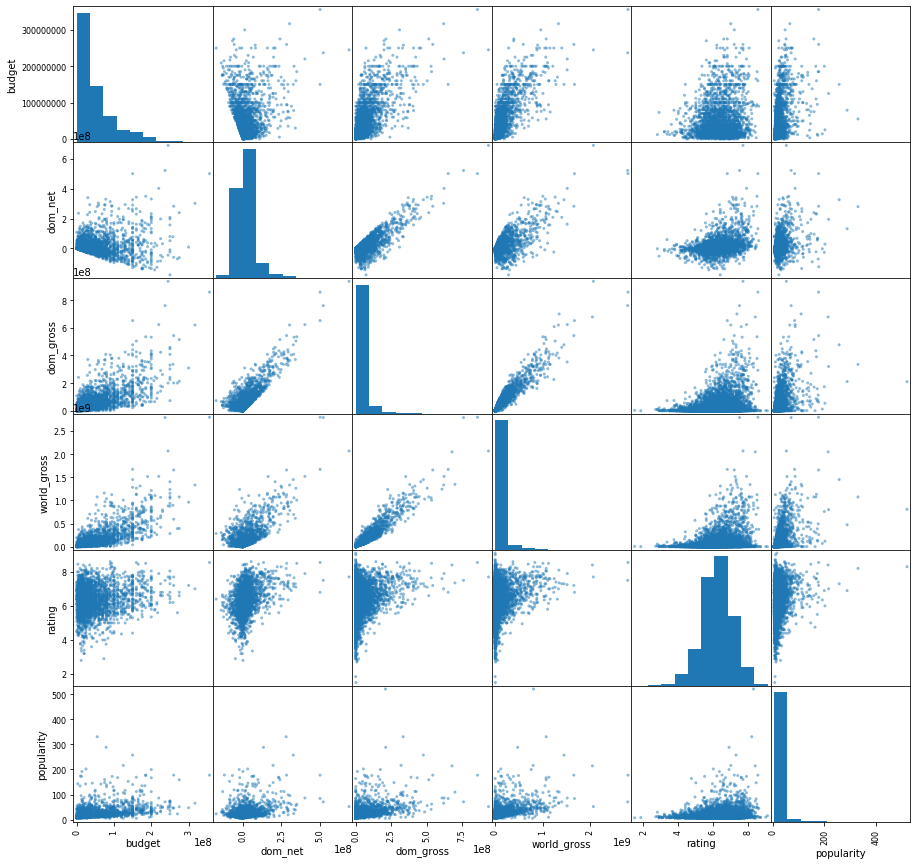

In [135]:
pd.plotting.scatter_matrix(master_movies[['budget', 'dom_net', 'dom_gross', 'world_gross', 'user_rating', 'popularity']], figsize=(15,15));

In [136]:
# investigate correlations with user_rating

master_movies.corr()['user_rating'].sort_values()

budget             0.155806
popularity         0.182417
for_gross          0.230390
world_gross        0.244406
dom_gross          0.250260
total_votes        0.272815
dom_net            0.328367
world_net          0.336573
runtime_minutes    0.374651
rating             1.000000
Name: rating, dtype: float64

In [137]:
master_movies.corr()['budget'].sort_values()

dom_net            0.114792
rating             0.155806
total_votes        0.370000
runtime_minutes    0.395186
popularity         0.404912
world_net          0.612776
dom_gross          0.678524
for_gross          0.737124
world_gross        0.739504
budget             1.000000
Name: budget, dtype: float64

In [138]:
master_movies.corr()['popularity'].sort_values()

rating             0.182417
runtime_minutes    0.259552
total_votes        0.322932
dom_net            0.346028
budget             0.404912
world_net          0.531689
dom_gross          0.539196
for_gross          0.566857
world_gross        0.572221
popularity         1.000000
Name: popularity, dtype: float64

In [139]:
master_movies.groupby('studio').mean().sort_values('dom_gross', ascending=False).head(10)
# sorting by average dom_gross, we see our top performing studios which produce the biggest blockbusters on average

# 349 studios made our 6749 movies

,runtime_minutes,popularity,rating,total_votes,budget,dom_gross,for_gross,world_gross,dom_net,world_net
studio,,,,,,,,,,
Walt Disney Studios Motion Pictures,114.980198,33.191787,6.628682,95262.717054,9.998087e+07,1.302921e+08,1.838667e+08,3.141588e+08,4.557510e+07,2.597751e+08
DreamWorks,101.500000,23.090667,6.485897,57799.410256,1.078667e+08,1.213017e+08,1.816577e+08,3.029594e+08,3.246940e+07,2.545042e+08
Sony Pictures Entertainment (SPE),110.686275,28.106445,6.235593,67518.423729,6.668173e+07,7.766886e+07,1.065173e+08,1.841862e+08,1.737262e+07,1.323928e+08
Warner Bros.,112.275132,27.729883,6.382282,84027.271845,6.685190e+07,7.475792e+07,1.027967e+08,1.775546e+08,1.506444e+07,1.242821e+08
Universal Pictures,109.580645,27.059218,6.306571,65901.826923,5.671801e+07,7.430772e+07,9.936894e+07,1.736767e+08,2.468006e+07,1.344538e+08
DreamWorks Distribution,NaN,21.183378,6.620000,2517.311111,5.330976e+07,7.288161e+07,7.866224e+07,1.515438e+08,1.969833e+07,9.507361e+07
Twentieth Century Fox,109.904412,27.561851,6.195101,70714.425676,6.139544e+07,7.165150e+07,1.132812e+08,1.849327e+08,1.944849e+07,1.499095e+08
Paramount Pictures,111.900990,24.502406,6.234703,82303.908676,6.115451e+07,6.857613e+07,8.121125e+07,1.497874e+08,1.195053e+07,9.973919e+07
Summit Entertainment,105.533333,25.799167,6.180000,74674.700000,3.714583e+07,5.546457e+07,7.570552e+07,1.311701e+08,3.037247e+07,1.227434e+08


In [140]:
master_movies.groupby('studio').sum().sort_values('dom_gross', ascending=False).head(10)
# sorting on domestic gross as a sum, we see which studios bring in the most overall gross


,runtime_minutes,popularity,rating,total_votes,budget,dom_gross,for_gross,world_gross,dom_net,world_net
studio,,,,,,,,,,
Walt Disney Studios Motion Pictures,11613.0,8563.481,1710.20,24577781.0,1.829650e+10,3.361536e+10,4.743761e+10,8.105297e+10,8.340244e+09,4.753884e+10
Warner Bros.,21220.0,11424.712,2629.50,34619236.0,2.112520e+10,3.080027e+10,4.235222e+10,7.315249e+10,4.760363e+09,3.927314e+10
Universal Pictures,16985.0,8442.476,1967.65,20561370.0,1.542730e+10,2.318401e+10,3.100311e+10,5.418712e+10,6.712976e+09,3.657142e+10
Twentieth Century Fox,14947.0,8158.308,1833.75,20931470.0,1.479630e+10,2.120885e+10,3.353124e+10,5.474009e+10,4.687086e+09,3.612819e+10
Sony Pictures Entertainment (SPE),11290.0,6633.121,1471.60,15934348.0,1.386980e+10,1.832985e+10,2.513809e+10,4.346794e+10,3.613504e+09,2.753770e+10
Paramount Pictures,11302.0,5366.027,1365.40,18024556.0,1.174166e+10,1.501817e+10,1.778526e+10,3.280344e+10,2.294502e+09,1.914992e+10
Lionsgate,15481.0,5998.275,1760.20,15148133.0,4.698500e+09,9.297121e+09,1.020053e+10,1.949765e+10,2.161959e+09,9.525562e+09
DreamWorks,1015.0,900.536,252.95,2254177.0,3.236000e+09,4.730766e+09,7.084649e+09,1.181542e+10,9.740821e+08,7.635127e+09
New Line Cinema,0.0,1702.284,531.40,141190.0,2.539500e+09,4.335141e+09,4.260189e+09,8.595330e+09,1.272928e+09,5.107651e+09


In [141]:
master_movies.groupby('studio').mean().sort_values('dom_net', ascending=False).head(10)
# sorting on domestic net on average, we get some interesting results. Our big flashy studios are still there,
# but there are some smaller studios that have a very respectable net income per film

,runtime_minutes,popularity,rating,total_votes,budget,dom_gross,for_gross,world_gross,dom_net,world_net
studio,,,,,,,,,,
Walt Disney Studios Motion Pictures,114.980198,33.191787,6.628682,95262.717054,9.998087e+07,1.302921e+08,1.838667e+08,3.141588e+08,4.557510e+07,2.597751e+08
Pantelion Films,109.666667,23.646000,6.400000,14073.000000,1.200000e+07,2.812711e+07,2.529748e+07,5.342458e+07,3.831612e+07,7.924491e+07
Newmarket Films,133.000000,14.756813,6.781250,8026.125000,1.981250e+07,2.908783e+07,2.336614e+07,5.245397e+07,3.729944e+07,8.306687e+07
DreamWorks,101.500000,23.090667,6.485897,57799.410256,1.078667e+08,1.213017e+08,1.816577e+08,3.029594e+08,3.246940e+07,2.545042e+08
United Artists Releasing,102.250000,52.235833,6.608333,5590.833333,1.525000e+07,3.564032e+07,3.203739e+07,6.767771e+07,3.174851e+07,7.686880e+07
Summit Entertainment,105.533333,25.799167,6.180000,74674.700000,3.714583e+07,5.546457e+07,7.570552e+07,1.311701e+08,3.037247e+07,1.227434e+08
Universal Pictures,109.580645,27.059218,6.306571,65901.826923,5.671801e+07,7.430772e+07,9.936894e+07,1.736767e+08,2.468006e+07,1.344538e+08
The Weinstein Company,110.066667,15.202820,6.680337,80956.955056,2.667308e+07,2.094307e+07,2.864001e+07,4.958308e+07,2.337187e+07,8.555096e+07
TriStar Pictures,109.521739,21.268560,6.536000,93003.760000,2.616364e+07,4.435558e+07,4.040665e+07,8.476222e+07,2.200991e+07,6.460271e+07


In [142]:
movies_withbudget.groupby('studio').mean().sort_values('dom_net', ascending=False).head(10)
# sorting on domestic net on average, we get some interesting results. Our big flashy studios are still there,
# but there are some smaller studios that have a very respectable domestic net income per film
# Pantelion films spent $12mil on a single film that ultimately netted $38mil domestic, which is only about $7mil less
# than the average Disney film nets domestically. Now, the WORLDWIDE net differs greatly ($79mil vs Disney's $260mil),
# but overall we can understand that we can get respectable results on a smaller budget if we do it right

,runtime_minutes,popularity,rating,total_votes,budget,dom_gross,for_gross,world_gross,dom_net,world_net
studio,,,,,,,,,,
Walt Disney Studios Motion Pictures,117.833333,34.202066,6.687705,112835.628415,9.998087e+07,1.455560e+08,2.142000e+08,3.597559e+08,4.557510e+07,2.597751e+08
Pantelion Films,112.000000,35.810000,6.250000,26525.000000,1.200000e+07,5.031612e+07,4.092879e+07,9.124491e+07,3.831612e+07,7.924491e+07
Newmarket Films,133.000000,18.527375,7.200000,15902.375000,1.981250e+07,5.711194e+07,4.576743e+07,1.028794e+08,3.729944e+07,8.306687e+07
DreamWorks,101.500000,25.335100,6.525000,74837.800000,1.078667e+08,1.403361e+08,2.220348e+08,3.623709e+08,3.246940e+07,2.545042e+08
United Artists Releasing,105.000000,62.209250,6.450000,7368.500000,1.525000e+07,4.699851e+07,4.512029e+07,9.211880e+07,3.174851e+07,7.686880e+07
Summit Entertainment,105.642857,27.516375,6.241667,89435.875000,3.714583e+07,6.751831e+07,9.237095e+07,1.598893e+08,3.037247e+07,1.227434e+08
Universal Pictures,109.910959,28.985088,6.315257,72291.430147,5.671801e+07,8.139807e+07,1.097737e+08,1.911718e+08,2.468006e+07,1.344538e+08
The Weinstein Company,112.631579,18.698308,6.988462,177856.115385,2.667308e+07,5.004495e+07,6.217908e+07,1.122240e+08,2.337187e+07,8.555096e+07
TriStar Pictures,108.285714,21.853500,6.595455,101956.500000,2.616364e+07,4.817355e+07,4.259280e+07,9.076634e+07,2.200991e+07,6.460271e+07


In [143]:
master_movies['studio'].value_counts()

Warner Bros.                           412
Universal Pictures                     312
Twentieth Century Fox                  296
Lionsgate                              282
Walt Disney Studios Motion Pictures    258
                                      ... 
Blackrock Films                          1
The American Film Company                1
Peaches Christ Productions               1
Content Media                            1
Hannover House                           1
Name: studio, Length: 349, dtype: int64

In [144]:
master_movies.groupby('genre_ids').mean().sort_values('dom_net', ascending=False)
# we have far too many genre combinations, so we need to find a way to break this out more

,runtime_minutes,popularity,rating,total_votes,budget,dom_gross,for_gross,world_gross,dom_net,world_net
genre_ids,,,,,,,,,,
"[18, 28, 80, 53]",NaN,61.787000,8.500000,23590.0,185000000.0,5.352340e+08,4.702227e+08,1.005457e+09,350234033.0,8.204568e+08
"[10751, 14, 10749]",129.0,56.161000,7.100000,251238.0,160000000.0,5.044812e+08,7.595832e+08,1.264064e+09,344481165.0,1.104064e+09
"[28, 12, 878, 14]",140.0,56.238500,7.225000,583157.5,211500000.0,5.460524e+08,7.601425e+08,1.306195e+09,334552357.0,1.094695e+09
"[878, 12, 14]",142.0,24.339000,7.150000,812271.0,78000000.0,4.080107e+08,2.863840e+08,6.943947e+08,330010692.0,6.163947e+08
"[12, 35, 16, 10751]",87.0,19.353000,6.350000,168458.0,75000000.0,3.683843e+08,5.070743e+08,8.754586e+08,293384330.0,8.004586e+08
...,...,...,...,...,...,...,...,...,...,...
"[99, 36, 10770]",NaN,8.520000,7.000000,56.0,NaN,1.482920e+05,1.482920e+05,2.965840e+05,NaN,NaN
"[99, 53]",98.0,5.900000,7.350000,1637.0,NaN,3.040700e+04,8.856000e+03,3.926300e+04,NaN,NaN
"[99, 9648, 53]",92.0,8.394000,7.450000,14082.0,NaN,6.139560e+05,1.765630e+05,7.905190e+05,NaN,NaN


## Studying some cast and crew info

In [145]:
cast_crew.columns

Index(['index', 'title', 'genre_ids', 'studio', 'runtime_minutes',
       'popularity', 'rating', 'total_votes', 'release_date', 'budget',
       'dom_gross', 'for_gross', 'world_gross', 'dom_net', 'world_net',
       'nconst', 'category', 'primary_name', 'death_year'],
      dtype='object')

In [146]:
cast_crew['category'].unique()
#What kinds of categories are tracked?

array([nan, 'actress', 'writer', 'director', 'actor', 'producer',
       'composer', 'cinematographer', 'editor', 'production_designer',
       'archive_footage', 'self', 'archive_sound'], dtype=object)

### Director

In [147]:
# make a new series based on the director of the movie
director = cast_crew[cast_crew['category'] == 'director']

In [148]:
# checking out our mean values for this group
director.groupby(['primary_name']).mean().sort_values('dom_net', ascending=False)
# We have 2608 different directors for our list of 6729 movies

,runtime_minutes,popularity,rating,total_votes,budget,dom_gross,for_gross,world_gross,dom_net,world_net,death_year
primary_name,,,,,,,,,,,
Colin Trevorrow,105.0,37.640000,6.933333,229617.333333,150000000.0,2.202622e+08,3.395454e+08,5.598076e+08,502270625.0,1.520401e+09,NaN
Joss Whedon,131.0,55.276667,7.450000,634991.333333,235000000.0,3.622309e+08,6.134245e+08,9.756554e+08,306181889.0,1.225813e+09,NaN
Jennifer Lee,102.0,172.424500,7.350000,267916.500000,150000000.0,4.390558e+08,9.263594e+08,1.365415e+09,289055793.5,1.215415e+09,NaN
Chris Buck,102.0,172.424500,7.350000,267916.500000,150000000.0,4.390558e+08,9.263594e+08,1.365415e+09,289055793.5,1.215415e+09,NaN
Patty Jenkins,141.0,72.788000,7.400000,502894.000000,149000000.0,4.125634e+08,4.092836e+08,8.218470e+08,263563408.0,6.728470e+08,NaN
...,...,...,...,...,...,...,...,...,...,...,...
Zara Hayes,91.0,17.017000,5.850000,828.000000,NaN,1.363112e+07,2.787094e+06,1.641822e+07,NaN,NaN,NaN
Zeek Earl,100.0,20.399000,6.100000,8975.000000,NaN,2.277700e+04,2.277700e+04,4.555400e+04,NaN,NaN,NaN
Zeresenay Mehari,99.0,6.460000,6.500000,1157.000000,NaN,4.966700e+04,4.753800e+04,9.720500e+04,NaN,NaN,NaN


In [149]:
# Checking how many movies each director has directed.
director.groupby(['primary_name']).count().value_counts('title')
#1776 of our directors have directed only one movie

title
1    1776
2     471
3     221
4      75
5      39
6      14
7       9
8       3
dtype: int64

In [150]:
# select directors that have directed at least 2 movies, so that we know they are proven
director = director[director.duplicated(subset='primary_name', keep=False)]

# checking out our mean values for this group
director.groupby(['primary_name']).mean().sort_values('dom_net', ascending=False)
# We have 832 repeat directors

,runtime_minutes,popularity,rating,total_votes,budget,dom_gross,for_gross,world_gross,dom_net,world_net,death_year
primary_name,,,,,,,,,,,
Colin Trevorrow,105.000000,37.640000,6.933333,229617.333333,150000000.0,2.202622e+08,3.395454e+08,5.598076e+08,5.022706e+08,1.520401e+09,NaN
Joss Whedon,131.000000,55.276667,7.450000,634991.333333,235000000.0,3.622309e+08,6.134245e+08,9.756554e+08,3.061819e+08,1.225813e+09,NaN
Jennifer Lee,102.000000,172.424500,7.350000,267916.500000,150000000.0,4.390558e+08,9.263594e+08,1.365415e+09,2.890558e+08,1.215415e+09,NaN
Chris Buck,102.000000,172.424500,7.350000,267916.500000,150000000.0,4.390558e+08,9.263594e+08,1.365415e+09,2.890558e+08,1.215415e+09,NaN
J.J. Abrams,126.666667,64.030250,7.162500,395942.000000,190000000.0,4.519119e+08,5.156033e+08,9.675152e+08,2.619119e+08,7.775152e+08,NaN
...,...,...,...,...,...,...,...,...,...,...,...
Xavier Gens,103.333333,19.567333,5.683333,16537.333333,NaN,2.479159e+06,2.479159e+06,4.958317e+06,NaN,NaN,NaN
Yoann-Karl Whissell,99.000000,13.933000,6.700000,23714.000000,NaN,5.454800e+04,5.454800e+04,1.090960e+05,NaN,NaN,NaN
Yoav Paz,94.500000,9.958000,5.450000,4833.000000,NaN,2.747315e+05,3.169565e+05,5.916880e+05,NaN,NaN,NaN


In [151]:
# Looking at the mean domestic gross of our top 30 directors
directortop30 = director.groupby(['primary_name'])['dom_gross'].mean().sort_values(ascending=False).nlargest(30)
directortop30

primary_name
Anthony Russo        5.512599e+08
Joe Russo            5.512599e+08
J.J. Abrams          4.519119e+08
Chris Buck           4.390558e+08
Jennifer Lee         4.390558e+08
Joss Whedon          3.622309e+08
Jon Favreau          3.300783e+08
Yarrow Cheney        3.195026e+08
Lee Unkrich          3.127324e+08
Brad Bird            3.038053e+08
Pierre Coffin        2.947346e+08
Rian Johnson         2.840103e+08
Andrew Stanton       2.796868e+08
Christopher Nolan    2.796190e+08
Ryan Coogler         2.754318e+08
Chris Renaud         2.721737e+08
Kyle Balda           2.715669e+08
Byron Howard         2.710451e+08
Gareth Edwards       2.443636e+08
Rich Moore           2.439276e+08
James Gunn           2.411058e+08
David Yates          2.395987e+08
Chris Williams       2.356424e+08
Francis Lawrence     2.298224e+08
Sam Mendes           2.212208e+08
Colin Trevorrow      2.202622e+08
Jake Kasdan          2.159229e+08
Tim Miller           2.126619e+08
Peter Jackson        2.086118e+08
A

AttributeError: module 'matplotlib' has no attribute 'title'

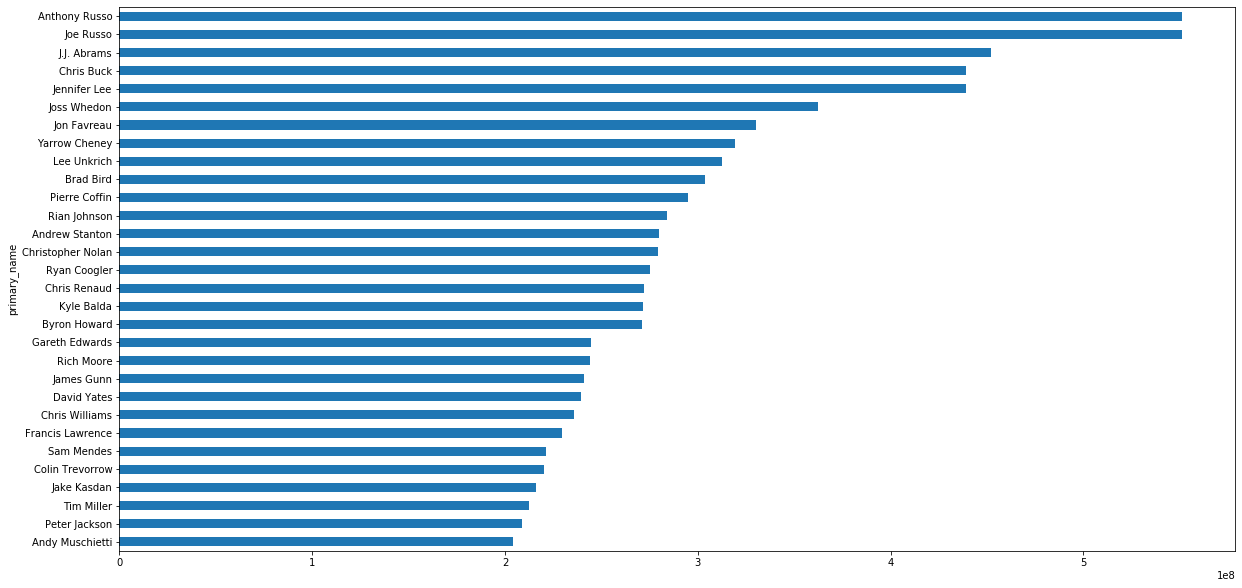

In [153]:
# Bar graph of the domestic gross of our top 30 directors
graphit = directortop30.sort_values().plot(kind='barh', figsize=(20,10))

plt.title('Mean Dom Gross by Director')
plt.xlabel('Domestic Gross')
plt.ylabel('Director')
graphit.plot();

### Actor

In [154]:
# checking out the actors in our top 30 grossing movies
actor = cast_crew[cast_crew['category'] == 'actor']
actor30 = actor.groupby(['primary_name'])['dom_gross'].max().sort_values(ascending=False).nlargest(30)
actor30

primary_name
John Boyega          936662225.0
Domhnall Gleeson     936662225.0
Oscar Isaac          936662225.0
Chris Evans          858373000.0
Robert Downey Jr.    858373000.0
Mark Ruffalo         858373000.0
Chris Hemsworth      858373000.0
Chadwick Boseman     700426566.0
Michael B. Jordan    700426566.0
Ty Simpkins          652270625.0
Chris Pratt          652270625.0
Jeremy Renner        623357910.0
Mark Hamill          620181382.0
Craig T. Nelson      608581744.0
Huck Milner          608581744.0
Chiwetel Ejiofor     543638043.0
James Earl Jones     543638043.0
Donald Glover        543638043.0
Seth Rogen           543638043.0
Alan Tudyk           532177324.0
Donnie Yen           532177324.0
Diego Luna           532177324.0
Adam Driver          515202542.0
Josh Gad             504481165.0
Dan Stevens          504481165.0
Luke Evans           504481165.0
Ed O'Neill           486295561.0
Albert Brooks        486295561.0
Sterling K. Brown    477373578.0
Jonathan Groff       477373578

AttributeError: module 'matplotlib' has no attribute 'title'

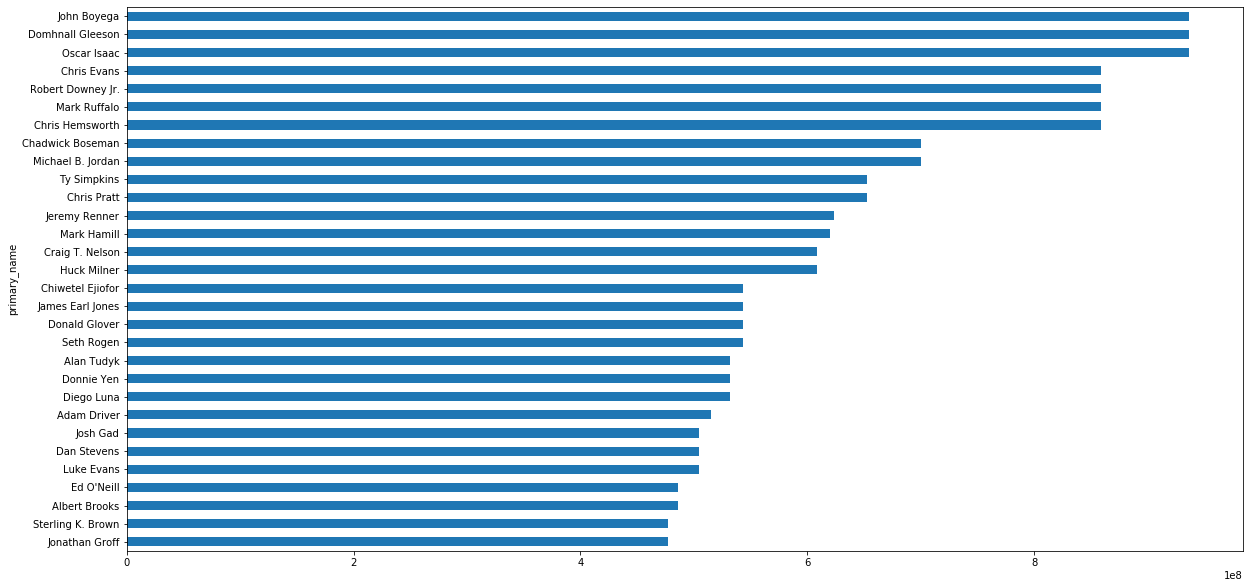

In [155]:
# Your code here
graphit = actor30.sort_values().plot(kind='barh', figsize=(20,10))

plt.title('Actors in Top 30 Grossing Movies')
plt.xlabel('Domestic Gross')
plt.ylabel('Actor')
graphit.plot();

In [156]:
# Looking at the mean domestic gross of the actors
actormean = actor.groupby(['primary_name'])['dom_gross'].mean().sort_values(ascending=False).nlargest(30)
actormean

primary_name
Huck Milner          6.085817e+08
Craig T. Nelson      6.085817e+08
Ed O'Neill           4.862956e+08
Donald Glover        3.787028e+08
Robert Downey Jr.    3.707680e+08
Neel Sethi           3.640011e+08
Ty Simpkins          3.531399e+08
Cole Konis           3.501264e+08
Pierre Coffin        3.360458e+08
Finn Wolfhard        3.288289e+08
Jonathan Groff       2.927223e+08
John Boyega          2.758384e+08
Orto Ignatiussen     2.740927e+08
James Earl Jones     2.724990e+08
Pharrell Williams    2.706210e+08
Bill Skarsgård       2.702111e+08
Trey Parker          2.646243e+08
Chris Evans          2.463482e+08
Jordan Peele         2.273149e+08
Scott Adsit          2.225278e+08
Gwilym Lee           2.166680e+08
Ben Hardy            2.166680e+08
David Schwimmer      2.163915e+08
Greg Grunberg        2.152889e+08
Josh Hutcherson      2.134900e+08
Anthony Gonzalez     2.104600e+08
Ned Beatty           2.076111e+08
Vin Diesel           2.072015e+08
Donnie Yen           2.052449e+08
C

In [157]:
# Looking at the actors by movie user_rating
actoruser_rating = actor[actor.duplicated(subset='primary_name', keep=False)]
actoruser_rating = actor.groupby(['primary_name'])['user_rating'].mean().sort_values(ascending=False).nlargest(30)
actoruser_rating

primary_name
John Killoran           8.700000
Hadley Fraser           8.550000
Ramin Karimloo          8.550000
Ben Fankhauser          8.400000
Andrew Keenan-Bolger    8.400000
Sebastian Maniscalco    8.300000
Anthony Gonzalez        8.300000
Tommy Caldwell          8.150000
Kevin Jorgeson          8.150000
Roman Griffin Davis     8.100000
Sunny Pawar             8.100000
David Rawle             8.050000
Gwilym Lee              8.000000
Ben Hardy               8.000000
Ferdia Walsh-Peelo      7.950000
Jerome Flynn            7.950000
Robert Gulaczyk         7.950000
Blair Jackson           7.900000
Frantz Turner           7.900000
Koyu Rankin             7.900000
Bob Balaban             7.900000
Louie Arnette           7.900000
Monty Muir              7.900000
Jonny Lee Miller        7.875000
F. Murray Abraham       7.875000
Neil Brown Jr.          7.850000
Kristyan Ferrer         7.850000
Leonardo DiCaprio       7.833333
Dave Johns              7.800000
Russell Hornsby         7.8000

### Actress

In [158]:
# checking out the actresses in our top 30 grossing movies
actress = cast_crew[cast_crew['category'] == 'actress']
actress30 = actress.groupby(['primary_name'])['dom_gross'].max().sort_values(ascending=False).nlargest(30)
actress30

primary_name
Daisy Ridley           936662225.0
Lupita Nyong'o         700426566.0
Danai Gurira           700426566.0
Bryce Dallas Howard    652270625.0
Judy Greer             652270625.0
Scarlett Johansson     623357910.0
Carrie Fisher          620181382.0
Holly Hunter           608581744.0
Sarah Vowell           608581744.0
Felicity Jones         532177324.0
Billie Lourd           515202542.0
Emma Watson            504481165.0
Ellen DeGeneres        486295561.0
Kaitlin Olson          486295561.0
Evan Rachel Wood       477373578.0
Kristen Bell           477373578.0
Anne Hathaway          448139099.0
Christina Hendricks    434038008.0
Brie Larson            426829839.0
Jennifer Lawrence      424668047.0
Joan Cusack            415004880.0
Gal Gadot              412563408.0
Lucy Davis             412563408.0
Robin Wright           412563408.0
Gwyneth Paltrow        409013994.0
Karen Gillan           404540171.0
Idina Menzel           400738009.0
Zendaya                390532085.0
Angouri

AttributeError: module 'matplotlib' has no attribute 'title'

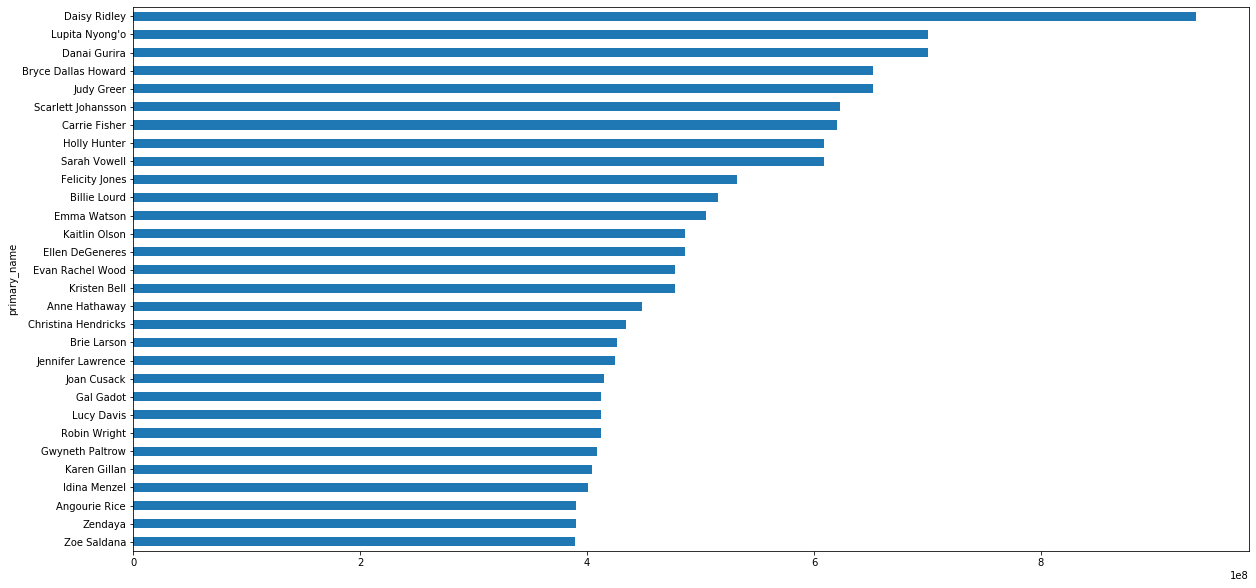

In [159]:
# Your code here
graphit = actress30.sort_values().plot(kind='barh', figsize=(20,10))

plt.title('Actresses in Top 30 Grossing Movies')
plt.xlabel('Domestic Gross')
plt.ylabel('Actress')
graphit.plot();

### Writer

In [160]:
# make a new series based on the writer of the movie
writer = cast_crew[cast_crew['category'] == 'writer']

In [161]:
# checking out our mean values for this group
writer.groupby(['primary_name']).mean().sort_values('dom_net', ascending=False)
# We have 3983 different writers for our list of 6729 movies

,runtime_minutes,popularity,rating,total_votes,budget,dom_gross,for_gross,world_gross,dom_net,world_net,death_year
primary_name,,,,,,,,,,,
Michael Crichton,126.0,98.441,6.60,391440.5,160000000.0,534995192.5,955437869.5,1.490433e+09,374995192.5,1.330433e+09,2008.0
Jeanne-Marie Leprince de Beaumont,129.0,56.161,7.10,251238.0,160000000.0,504481165.0,759583221.0,1.264064e+09,344481165.0,1.104064e+09,1780.0
Gabrielle-Suzanne Barbot de Villeneuve,129.0,56.161,7.10,251238.0,160000000.0,504481165.0,759583221.0,1.264064e+09,344481165.0,1.104064e+09,1755.0
Stephen Chbosky,129.0,56.161,7.10,251238.0,160000000.0,504481165.0,759583221.0,1.264064e+09,344481165.0,1.104064e+09,NaN
John Knoll,133.0,40.837,7.65,490033.0,200000000.0,532177324.0,523880396.0,1.056058e+09,332177324.0,8.560577e+08,NaN
...,...,...,...,...,...,...,...,...,...,...,...
Zane,106.0,17.601,5.35,7809.0,NaN,17390770.0,143544.0,1.753431e+07,NaN,NaN,NaN
Zeb Wells,86.0,12.442,5.30,4506.0,NaN,157768.0,157768.0,3.155360e+05,NaN,NaN,NaN
Zina Zaflow,85.0,15.661,5.95,1944.0,NaN,10800715.0,10800715.0,2.160143e+07,NaN,NaN,NaN


In [162]:
# Checking how many movies each writer has written.
writer.groupby(['primary_name']).count().value_counts('title')
# over half of

title
1     3094
2      513
3      203
4       86
5       46
6       20
7        9
8        6
10       3
17       1
13       1
9        1
dtype: int64

In [163]:
# Looking at the mean domestic gross of our top 30 writers
writertop30 = writer.groupby(['primary_name'])['dom_gross'].mean().sort_values(ascending=False).nlargest(30)
writertop30

primary_name
Joe Robert Cole                           7.004266e+08
Lawrence Kasdan                           5.752149e+08
Brenda Chapman                            5.436380e+08
Michael Crichton                          5.349952e+08
John Knoll                                5.321773e+08
Gabrielle-Suzanne Barbot de Villeneuve    5.044812e+08
Jeanne-Marie Leprince de Beaumont         5.044812e+08
Stephen Chbosky                           5.044812e+08
Victoria Strouse                          4.862956e+08
George Lucas                              4.717368e+08
Colin Trevorrow                           4.664612e+08
Valerie LaPointe                          4.340380e+08
Rashida Jones                             4.340380e+08
Andrew Stanton                            4.245214e+08
Jim Starlin                               4.244095e+08
William Moulton Marston                   4.125634e+08
Allan Heinberg                            4.125634e+08
Harry G. Peter                            4.125634e+

AttributeError: module 'matplotlib' has no attribute 'title'

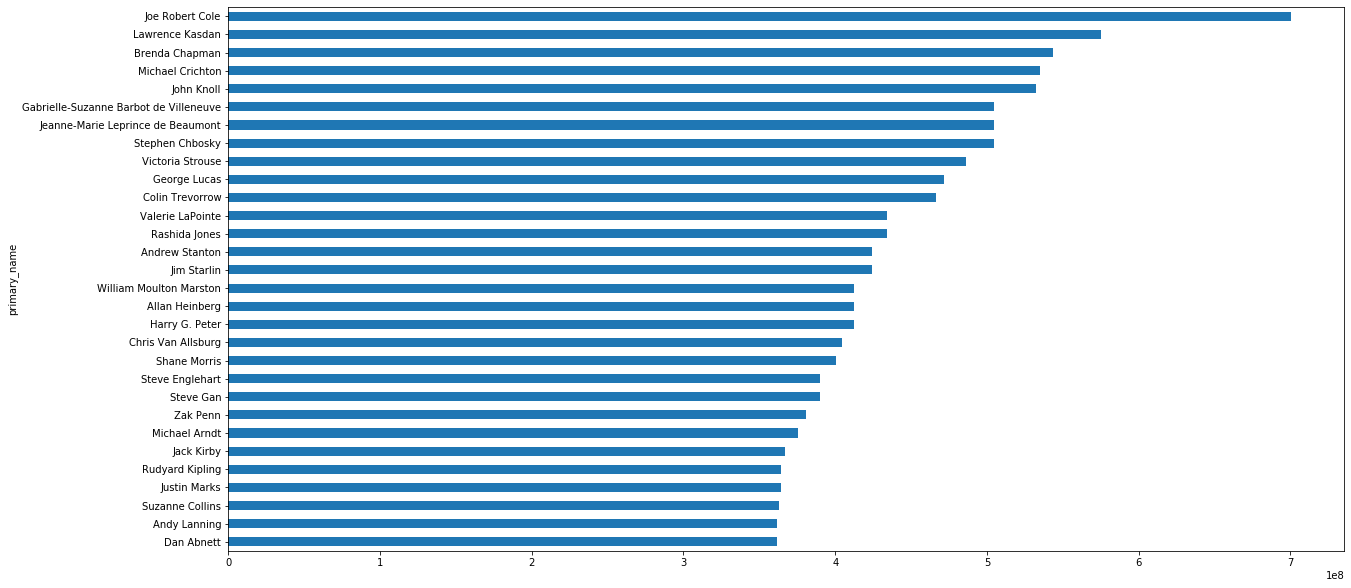

In [164]:
# Bar graph of the domestic gross of our top 30 directors
graphit = writertop30.sort_values().plot(kind='barh', figsize=(20,10))
#deaths = df.groupby(['State'])['Deaths'].sum().sort_values().plot(kind='barh', figsize=(20,10))

plt.title('Dom Gross by Writer')
plt.xlabel('Domestic Gross')
plt.ylabel('Director')
graphit.plot();

# TO DO

Map genre names to numbers (just being lazy... should do this now, no real excuse that it's not done yet)

Break out franchises (by looking at duplicate words in movie titles and then manually? ?), study franchises vs single films ?
Feature engineering - add "Franchise" field? (look up library to ignore dumb words)? Look up how to perform feature engineering on non-categorical data.

Break out genres, and study numbers vs genre

Visualizations/EDA to gather:
    gross/net by team of writer-director
    gross/net of franchise vs non-franchise
    gross/net by genre
    gross/net by genre+franchise status
    gross/net against studio
    check out genres of franchises